# **Système Intelligent de matching Patients - Praticiens**

Ce notebook présente le développement complet d’un système automatisé d’association entre patients et praticiens, intégrant l’ingénierie des caractéristiques, la modélisation machine learning multi-algorithmes, un algorithme avancé de matching et la génération de rapports professionnels.


## **Table des Matières**

1. Phase 1 : Importation des Bibliothèques & Préparation de l’Environnement  
2. Phase 2 : Chargement & Prétraitement des Données  
3. Phase 3 : Ingénierie des Caractéristiques (Feature Engineering)  
4. Phase 4 : Modélisation Multi-Algorithme  
5. Phase 5 : Préparation des Données d’Entraînement & Apprentissage  
6. Phase 6 : Algorithme Avancé de Matching avec Suivi de Progression  
7. Phase 7 : Génération de Rapports & Visualisations  
8. Phase 8 : Synthèse du Modèle, Fonctionnement & Intérêt du Matching Intelligent  

---


## **Phase 1 : Importation des Bibliothèques & Préparation de l’Environnement**

- Installation et importation des bibliothèques nécessaires (pandas, numpy, sklearn, lightgbm, fpdf, tqdm, etc.)
- Préparation de l’environnement pour l’analyse, la modélisation, la visualisation et la génération de rapports




In [ ]:
!pip install matplotlib seaborn pandas numpy scikit-learn fpdf lightgbm tqdm


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=7a79f279992faee03fee289e40bc47c71e9d2c793751c0f45300cbc79ffd6c3d
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [ ]:
#  Essential Libraries for Data Analysis and Machine Learning
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Machine Learning Components
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, precision_score,
    recall_score, f1_score, matthews_corrcoef, log_loss,
    balanced_accuracy_score
)
import lightgbm as lgb

# Utility Libraries
from collections import defaultdict
import ast
from fpdf import FPDF
import os
import time

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## **Phase 2: Data Loading & Preprocessing**

- Chargement des données patients et praticiens depuis CSV
- Nettoyage des colonnes listes (diagnostics) et conversion en listes Python
- Transformation des variables catégorielles en variables booléennes numériques
- Validation et aperçu des données nettoyées

In [ ]:
import pandas as pd
import ast

# 📁 Data Loading and Cleaning Functions
def load_data(
    patients_file='Processed_Patients.csv',
    practitioners_file='Processed_Praticiens.csv'
):
    """
    Loads and preprocesses patient and practitioner data from CSV files.

    Returns:
        tuple: (patients_df, practitioners_df) - cleaned DataFrames
    """
    # Load raw data
    patients_df = pd.read_csv(patients_file)
    practitioners_df = pd.read_csv(practitioners_file)

    def clean_list_column(s):
        """
        Safely converts string representations of lists to actual Python lists.
        Handles edge cases like empty strings, NaN values, and malformed data.
        """
        if pd.isna(s) or s == '[]':
            return []
        try:
            # Try to evaluate as a Python literal (safe evaluation)
            return ast.literal_eval(s) if s.startswith('[') else [s.strip()]
        except:
            # Fallback for malformed data
            return []

    # Clean diagnostic lists (convert string representations to actual lists)
    patients_df['diagnostics_clean'] = patients_df['diagnostics'].apply(clean_list_column)
    practitioners_df['required_diagnostics_clean'] = practitioners_df['required_diagnostics'].apply(clean_list_column)

    # Convert categorical variables to binary (0/1) for ML processing
    # Gingivitis: 'non' becomes 0, everything else becomes 1
    patients_df['has_gingivite_bool'] = (patients_df['has_gingivite'] != 'non').astype(int)
    practitioners_df['needs_gingivite_bool'] = (practitioners_df['needs_gingivite'] != 'non').astype(int)

    # Tartar: 'oui' becomes 1, everything else becomes 0
    patients_df['has_tartre_bool'] = (patients_df['has_tartre'] == 'oui').astype(int)
    practitioners_df['needs_tartre_bool'] = (practitioners_df['needs_tartre'] == 'oui').astype(int)

    return patients_df, practitioners_df


# Load and inspect the data
patients_df, practitioners_df = load_data()

print(f"📈 Data loaded successfully!")
print(f"👥 Patients: {len(patients_df)} records")
print(f"👨‍⚕️ Practitioners: {len(practitioners_df)} records")

# Afficher un tableau avec les premières lignes des colonnes diagnostics_clean et required_diagnostics_clean
print("\n🔍 Sample patient diagnostics (first 5 rows):")
display(patients_df.head())

print("\n🔍 Sample practitioner required diagnostics (first 5 rows):")
display(practitioners_df.head())


📈 Data loaded successfully!
👥 Patients: 182 records
👨‍⚕️ Practitioners: 183 records

🔍 Sample patient diagnostics (first 5 rows):


,id,diagnostics,treatment,has_gingivite,has_tartre,diagnostics_clean,has_gingivite_bool,has_tartre_bool
0,Gwery _Bouchra_0,['categorie_2_baume'],coiffage_pulpaire,non,oui,[categorie_2_baume],0,1
1,Bouchair_Hanane_1,['categorie_2_baume'],restauration_simple_composite,localisee,oui,[categorie_2_baume],1,1
2,Merzongne_Roumaima_2,['categorie_2_baume'],restauration_directe,non,oui,[categorie_2_baume],0,1
3,Atia_Naima_3,['categorie_2_baume'],restauration_composite,localisee,non,[categorie_2_baume],1,0
4,Fellah_Fethi_4,['categorie_2_baume'],restauration_simple_composite,non,non,[categorie_2_baume],0,0



🔍 Sample practitioner required diagnostics (first 5 rows):


,id,required_diagnostics,required_treatment,needs_gingivite,needs_tartre,required_diagnostics_clean,needs_gingivite_bool,needs_tartre_bool
0,Guerni_Sarra,['categorie_2_baume'],coiffage_pulpaire,non,oui,[categorie_2_baume],0,1
1,redjem_Fatima,"['categorie_1_baume', 'apd_profonde', 'categor...",restauration_simple_composite,localisee,oui,"[categorie_1_baume, apd_profonde, categorie_4_...",1,1
2,Boubekeur_Souhila,"['apd', 'categorie_2_baume', 'categorie_4_baum...",restauration_directe,non,oui,"[apd, categorie_2_baume, categorie_4_baume, ca...",0,1
3,Berouas_Assia,['categorie_2_baume'],restauration_composite,localisee,non,[categorie_2_baume],1,0
4,Benbrahim_Imad,['categorie_2_baume'],restauration_simple_composite,non,non,[categorie_2_baume],0,0


## **Phase 3 : Ingénierie des Caractéristiques (Feature Engineering)**

### **Objectif**

L’ingénierie des caractéristiques consiste à transformer les données brutes en variables quantitatives pertinentes, exploitables par les modèles d’apprentissage automatique. Cette étape est cruciale car la qualité des caractéristiques influence directement la performance des modèles prédictifs.

### **Description détaillée**

Dans ce projet, l’objectif est de mesurer la **compatibilité** entre un patient et un praticien selon plusieurs critères cliniques et organisationnels. Pour cela, nous construisons plusieurs variables numériques qui traduisent les relations complexes entre leurs profils respectifs :

1. **Analyse de la similarité diagnostique**

   - **Intersection des diagnostics** :  
     On calcule le nombre de diagnostics que le patient et le praticien ont en commun, c’est-à-dire la taille de l’intersection entre leurs listes de diagnostics.  
     *Exemple : si un patient a ["carie", "gingivite"] et un praticien traite ["carie", "parodontite"], l’intersection est ["carie"], donc taille = 1.*

   - **Coefficient de Jaccard** :  
     C’est un indice qui mesure la similarité entre deux ensembles en rapportant la taille de leur intersection à la taille de leur union.  
     Il varie entre 0 (aucun diagnostic commun) et 1 (diagnostics identiques).  

2. **Indicateurs binaires de correspondance**

   - **Correspondance du traitement requis** :  
     Variable binaire valant 1 si le traitement demandé par le patient correspond exactement au traitement que le praticien peut fournir, sinon 0.

   - **Correspondance sur la gingivite** :  
     Variable binaire indiquant si la présence ou absence de gingivite chez le patient correspond à la spécialisation du praticien (ex : patient avec gingivite et praticien qui traite la gingivite).

   - **Correspondance sur le tartre** :  
     Même principe que pour la gingivite, mais appliqué à la présence ou non de tartre.

3. **Mesures de complexité**

   - **Complexité du patient** :  
     Calculée comme la somme du nombre total de diagnostics plus la présence ou absence de gingivite et de tartre (valeurs binaires).  
     Cela reflète la charge clinique du patient.

   - **Capacité du praticien** :  
     Somme similaire sur les diagnostics que le praticien peut traiter et les affections spécifiques qu’il prend en charge.

   - **Différence de complexité** :  
     Valeur absolue de la différence entre la complexité du patient et la capacité du praticien.  
     Elle renseigne sur l’adéquation globale entre la difficulté du cas et la capacité à la traiter.

4. **Règles métier intégrées**

   Avant d’utiliser ces caractéristiques dans un modèle ML, une fonction d’**évaluation basique de compatibilité** est définie selon des règles cliniques validées, pour filtrer les paires incohérentes (exemple : traitements incompatibles ou aucun diagnostic commun).

---

### **Pourquoi cette phase est-elle essentielle ?**

- Elle permet de **quantifier des critères qualitatifs** complexes, ce qui est indispensable pour entraîner des modèles d’apprentissage automatique efficaces.
- Elle garantit que les modèles auront des données **informatives et discriminantes** pour apprendre à prédire la compatibilité.
- Elle combine des connaissances métier (règles cliniques) avec des techniques mathématiques (coefficient de Jaccard), assurant une cohérence et une pertinence clinique.
- En résumé, sans une ingénierie des caractéristiques bien conçue, même les meilleurs modèles ML ne pourraient pas donner de bonnes prédictions.

---

### **Illustration schématique simplifiée**

| Caractéristique          | Description                           | Type       | Rôle                         |
|-------------------------|-----------------------------------|------------|------------------------------|
| diag_intersection       | Nombre de diagnostics communs       | Numérique  | Mesure la similarité directe |
| diag_jaccard            | Coefficient de Jaccard               | Numérique  | Mesure la similarité relative|
| treatment_match         | Traitement patient = praticien ?    | Binaire    | Vérifie la correspondance    |
| gingivitis_match        | Présence gingivite correspondante   | Binaire    | Affection spécifique         |
| tartre_match            | Présence tartre correspondante      | Binaire    | Affection spécifique         |
| patient_complexity      | Charge clinique patient              | Numérique  | Complexité globale           |
| practitioner_capacity   | Capacité de traitement praticien    | Numérique  | Capacité globale             |
| complexity_diff         | Différence complexité patient-praticien | Numérique | Écart de charge-clinique     |

---



In [ ]:
#  Feature Engineering for Compatibility Scoring
class FeatureEngineer:
    def calculate_compatibility_features(self, patient, practitioner):
        """
        Calculates numerical features that quantify patient-practitioner compatibility.
        These features feed into the machine learning model.

        Args:
            patient: Patient row from DataFrame
            practitioner: Practitioner row from DataFrame

        Returns:
            dict: Feature values for ML model
        """
        # 🔍 Set operations for diagnostic overlap analysis
        patient_diags = set(patient['diagnostics_clean'])
        practitioner_diags = set(practitioner['required_diagnostics_clean'])
        intersection = patient_diags & practitioner_diags  # Common diagnostics
        union = patient_diags | practitioner_diags  # All unique diagnostics

        return {
            # 📊 Diagnostic Compatibility Metrics
            'diag_intersection': len(intersection),  # How many diagnostics match
            'diag_jaccard': len(intersection) / len(union) if union else 0,  # Jaccard similarity (0-1)

            # ✅ Exact Match Indicators (binary features)
            'treatment_match': int(patient['treatment'] == practitioner['required_treatment']),
            'gingivitis_match': int(patient['has_gingivite_bool'] == practitioner['needs_gingivite_bool']),
            'tartre_match': int(patient['has_tartre_bool'] == practitioner['needs_tartre_bool']),

            # 🧮 Complexity Measures
            'patient_complexity': len(patient['diagnostics_clean']) + patient['has_gingivite_bool'] + patient['has_tartre_bool'],
            'practitioner_capacity': len(practitioner['required_diagnostics_clean']) + practitioner['needs_gingivite_bool'] + practitioner['needs_tartre_bool'],
            'complexity_diff': abs((len(patient['diagnostics_clean']) + patient['has_gingivite_bool'] + patient['has_tartre_bool']) -
                                   (len(practitioner['required_diagnostics_clean']) + practitioner['needs_gingivite_bool'] + practitioner['needs_tartre_bool']))
        }

    def is_compatible(self, patient, practitioner):
        """
        Determines basic compatibility using business rules.
        This is the foundation before ML refinement.

        Returns:
            bool: True if compatible, False otherwise
        """
        #  Fundamental requirement: Treatment types must match
        if patient['treatment'] != practitioner['required_treatment']:
            return False

        #  Diagnostic compatibility check
        # Practitioner must be able to treat at least one patient diagnostic
        # (unless practitioner has no specific diagnostic requirements)
        patient_diags = set(patient['diagnostics_clean'])
        practitioner_diags = set(practitioner['required_diagnostics_clean'])

        if not (patient_diags & practitioner_diags) and practitioner_diags:
            return False

        #  Gingivitis compatibility logic
        gingivite_compat = (
            (patient['has_gingivite'] == 'non' and practitioner['needs_gingivite'] == 'non') or
            (patient['has_gingivite'] != 'non' and practitioner['needs_gingivite'] == 'localisee') or
            (patient['has_gingivite'] == 'oui' and practitioner['needs_gingivite'] == 'oui')
        )

        #  Tartar compatibility logic
        tartre_compat = (patient['has_tartre'] == practitioner['needs_tartre']) or practitioner['needs_tartre'] == 'non'

        return gingivite_compat and tartre_compat

#  Test the feature engineering
engineer = FeatureEngineer()
print("✅ Feature Engineering class initialized")

# Test with first patient and practitioner
if len(patients_df) > 0 and len(practitioners_df) > 0:
    sample_features = engineer.calculate_compatibility_features(
        patients_df.iloc[0],
        practitioners_df.iloc[0]
    )
    print(f" Sample features: {sample_features}")

✅ Feature Engineering class initialized
 Sample features: {'diag_intersection': 1, 'diag_jaccard': 1.0, 'treatment_match': 1, 'gingivitis_match': 1, 'tartre_match': 1, 'patient_complexity': np.int64(2), 'practitioner_capacity': np.int64(2), 'complexity_diff': np.int64(0)}


##**Phase 4 : Modélisation Multi-Algorithme**

###**Objectif**

L’objectif de cette phase est de construire plusieurs modèles d’apprentissage automatique capables de prédire la compatibilité entre un patient et un praticien, à partir des caractéristiques numériques extraites lors de la phase précédente.

###**Modèles utilisés**

Nous avons choisi trois modèles complémentaires, réputés pour leur efficacité en classification binaire :

1. **Arbre de Décision (Decision Tree)**  
   Modèle simple et interprétable, qui segmente l’espace des caractéristiques en fonction de règles successives.  
   Paramètres principaux : profondeur maximale, nombre minimum d’échantillons par noeud.

2. **Forêt Aléatoire (Random Forest)**  
   Ensemble d’arbres de décision entraînés sur des sous-échantillons aléatoires des données et des variables.  
   Permet d’améliorer la robustesse et la généralisation par réduction de la variance.

3. **LightGBM**  
   Modèle de boosting gradientiel, basé sur des arbres de décision, qui construit les arbres de façon séquentielle pour corriger les erreurs des arbres précédents.  
   Très efficace sur des datasets complexes et volumineux, avec un bon compromis précision/temps.

###**Processus d’entraînement**

- Les données sont divisées en ensembles d’entraînement (80%) et de test (20%) de manière stratifiée pour conserver la proportion des classes.  
- Chaque modèle est entraîné sur les caractéristiques extraites (features) avec la variable cible binaire `is_compatible`.  
- Le temps d’entraînement est mesuré pour chaque modèle.

###**Évaluation des performances**

Pour chaque modèle, plusieurs métriques sont calculées sur l’ensemble test :

- **Accuracy (Précision globale)**  
- **Precision (Précision positive)**  
- **Recall (Rappel ou sensibilité)**  
- **F1-score (Moyenne harmonique précision/rappel)**  
- **AUC ROC (Surface sous la courbe ROC)**  
- **MCC (Coefficient de corrélation de Matthews)**  
- **Log Loss (Perte logarithmique)**  
- **Balanced Accuracy (Accuracy équilibrée)**

###**Visualisations réalisées**

- Comparaison graphique des performances (barres pour chaque métrique par modèle)  
- Courbes ROC et Precision-Recall superposées  
- Diagrammes d’arbres pour le modèle Decision Tree et un arbre exemple de Random Forest  
- Visualisation de l’arbre de LightGBM ayant le meilleur gain d’information  
- Importance relative des variables pour chaque modèle

---

###**Importance de cette phase**

- Permet de comparer la capacité prédictive des différents modèles sur la tâche spécifique d’évaluation de compatibilité.  
- Aide à sélectionner le modèle le plus adapté, équilibrant précision, complexité et temps de calcul.  
- Les visualisations et rapports facilitent la compréhension et la communication des résultats aux décideurs.

---


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, matthews_corrcoef, log_loss,
                             balanced_accuracy_score, roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import train_test_split
import lightgbm as lgb

output_dir = "./model_results/TrainingResults"
os.makedirs(output_dir, exist_ok=True)
class MultiModelPredictor:
    def __init__(self):
        self.feature_columns = ['diag_intersection', 'diag_jaccard', 'treatment_match',
                                'gingivitis_match', 'tartre_match', 'patient_complexity',
                                'practitioner_capacity', 'complexity_diff']

        self.models = {
            'Decision Tree': DecisionTreeClassifier(
                max_depth=8,
                random_state=42,
                min_samples_split=10,
                min_samples_leaf=5
            ),
            'Random Forest': RandomForestClassifier(
                n_estimators=100,
                max_depth=8,
                random_state=42,
                min_samples_split=10,
                min_samples_leaf=5,
                n_jobs=-1
            ),
            'LightGBM': lgb.LGBMClassifier(
                n_estimators=100,
                max_depth=8,
                random_state=42,
                min_child_samples=10,
                num_leaves=31,
                verbose=-1
            )
        }

        self.trained_models = {}
        self.model_metrics = {}
        self.is_trained = False

    def train_all_models(self, feature_df):
        print("🚀 Starting multi-model training...")

        expected_columns = self.feature_columns + ['is_compatible']
        for col in expected_columns:
            if col not in feature_df.columns:
                raise ValueError(f"❌ Missing column: '{col}' in the dataset")

        if feature_df[self.feature_columns].isnull().any().any():
            raise ValueError("❌ Missing values detected in feature columns. Please fill or drop them.")

        non_numeric = feature_df[self.feature_columns].select_dtypes(exclude=[np.number])
        if not non_numeric.empty:
            raise ValueError(f"❌ Non-numeric feature columns detected: {list(non_numeric.columns)}")

        unique_targets = feature_df['is_compatible'].dropna().unique()
        if not set(unique_targets).issubset({0, 1}):
            raise ValueError(f"❌ 'is_compatible' must contain only binary values (0 and 1), found: {unique_targets}")

        X = feature_df[self.feature_columns]
        y = feature_df['is_compatible']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, test_size=0.2, random_state=42
        )

        for model_name, model in self.models.items():
            print(f"\n🔄 Training {model_name}...")
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time

            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]

            metrics = self._calculate_metrics(y_test, y_pred, y_proba, training_time)

            self.trained_models[model_name] = model
            self.model_metrics[model_name] = metrics

            print(f"✅ {model_name} trained successfully")
            print(f"   📊 Accuracy: {metrics['accuracy']:.3f}")
            print(f"   ⏱️ Training time: {metrics['training_time']:.2f}s")

        self.is_trained = True

        # Visualisations + rapports
        self._create_model_comparison_visualizations(X_test, y_test)
        self._generate_confusion_matrices(X_test, y_test, output_dir)
        self._export_decision_tree_diagram(output_dir)
        self._export_random_forest_tree_diagram(output_dir, tree_index=0)
        self._export_lightgbm_best_gain_tree(output_dir)
        self._generate_metrics_pdf_report(output_dir)

        self.print_all_metrics()

    def _calculate_metrics(self, y_test, y_pred, y_proba, training_time):
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
        recall_vals, precision_vals = zip(*sorted(zip(recall_vals, precision_vals)))

        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1_score': f1_score(y_test, y_pred, zero_division=0),
            'specificity': tn / (tn + fp) if (tn + fp) else 0,
            'matthews_corrcoef': matthews_corrcoef(y_test, y_pred),
            'log_loss': log_loss(y_test, y_proba),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'auc_roc': auc(*roc_curve(y_test, y_proba)[:2]),
            'auc_pr': auc(recall_vals, precision_vals),
            'training_time': training_time,
            'true_positives': tp,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn
        }

    def _create_model_comparison_visualizations(self, X_test, y_test):
        output_dir = "./model_results/TrainingResults"
        os.makedirs(output_dir, exist_ok=True)

        model_names = list(self.model_metrics.keys())

        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
        x = np.arange(len(model_names))
        width = 0.15

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

        ax1 = axes[0, 0]
        for i, metric in enumerate(metrics_to_plot):
            values = [self.model_metrics[model][metric] for model in model_names]
            ax1.bar(x + i * width, values, width, label=metric.replace('_', ' ').title())
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Score')
        ax1.set_title('Performance Metrics Comparison')
        ax1.set_xticks(x + width * 2)
        ax1.set_xticklabels(model_names)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        training_times = [self.model_metrics[model]['training_time'] for model in model_names]
        bars = ax2.bar(model_names, training_times, color=['skyblue', 'lightgreen', 'lightcoral'])
        ax2.set_ylabel('Training Time (seconds)')
        ax2.set_title('Training Time Comparison')
        ax2.grid(True, alpha=0.3)
        for bar, time_val in zip(bars, training_times):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                     f'{time_val:.2f}s', ha='center', va='bottom')

        ax3 = axes[0, 2]
        colors = ['blue', 'green', 'red']
        for i, (model_name, model) in enumerate(self.trained_models.items()):
            y_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc = auc(fpr, tpr)
            ax3.plot(fpr, tpr, color=colors[i], lw=2,
                     label=f'{model_name} (AUC = {roc_auc:.3f})')
        ax3.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.set_title('ROC Curves Comparison')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 0]
        for i, (model_name, model) in enumerate(self.trained_models.items()):
            y_proba = model.predict_proba(X_test)[:, 1]
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
            pr_auc = auc(recall_vals, precision_vals)
            ax4.plot(recall_vals, precision_vals, color=colors[i], lw=2,
                     label=f'{model_name} (AUC = {pr_auc:.3f})')
        ax4.set_xlabel('Recall')
        ax4.set_ylabel('Precision')
        ax4.set_title('Precision-Recall Curves Comparison')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        ax5 = axes[1, 1]
        if all(hasattr(self.trained_models[m], 'feature_importances_') for m in ['Decision Tree', 'Random Forest', 'LightGBM']):
            dt_imp = self.trained_models['Decision Tree'].feature_importances_
            rf_imp = self.trained_models['Random Forest'].feature_importances_
            lgb_imp = self.trained_models['LightGBM'].feature_importances_
            lgb_imp = lgb_imp / lgb_imp.sum()
            x = np.arange(len(self.feature_columns))
            width = 0.25
            ax5.bar(x - width, dt_imp, width, label='Decision Tree', alpha=0.8)
            ax5.bar(x, rf_imp, width, label='Random Forest', alpha=0.8)
            ax5.bar(x + width, lgb_imp, width, label='LightGBM', alpha=0.8)
            ax5.set_xlabel('Features')
            ax5.set_ylabel('Importance')
            ax5.set_title('Feature Importance Comparison')
            ax5.set_xticks(x)
            ax5.set_xticklabels([f.replace('_', '\n') for f in self.feature_columns], rotation=45, ha='right')
            ax5.legend()
            ax5.grid(True, alpha=0.3)

        axes[1, 2].axis('off')

        plt.tight_layout()
        comp_path = os.path.join(output_dir, "model_comparison.png")
        fig.savefig(comp_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📊 Model comparison figure saved as '{comp_path}'")

        # Confusion matrices side-by-side
        fig_cm, axs = plt.subplots(1, len(model_names), figsize=(5 * len(model_names), 4))
        if len(model_names) == 1:
            axs = [axs]
        for ax, model_name in zip(axs, model_names):
            y_pred = self.trained_models[model_name].predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                        xticklabels=['Incompatible', 'Compatible'],
                        yticklabels=['Incompatible', 'Compatible'])
            ax.set_title(f'Confusion Matrix\n{model_name}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        plt.tight_layout()
        cm_path = os.path.join(output_dir, "confusion_matrices_side_by_side.png")
        fig_cm.savefig(cm_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📊 Confusion matrices side-by-side saved at: '{cm_path}'")

    def print_all_metrics(self):
        print("\n" + "="*80)
        print("📊 COMPREHENSIVE MODEL METRICS")
        print("="*80)

        data = []
        for model_name, metrics in self.model_metrics.items():
            row = {'Model': model_name}
            for key in ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'matthews_corrcoef', 'training_time']:
                val = metrics[key]
                if isinstance(val, float):
                    val = round(val, 4)
                row[key.replace('_', ' ').title()] = val
            data.append(row)

        df = pd.DataFrame(data)

        # Styling pour jolie table dans console Jupyter par ex.
        try:
            styled = df.style.format({
                'Accuracy': "{:.4f}",
                'Precision': "{:.4f}",
                'Recall': "{:.4f}",
                'F1 Score': "{:.4f}",
                'Auc Roc': "{:.4f}",
                'Matthews Corrcoef': "{:.4f}",
                'Training Time': "{:.2f}s"
            })
            from IPython.display import display
            display(styled)
        except ImportError:
            # Sinon print simple
            print(df.to_string(index=False))

        print("\n🏆 BEST PERFORMING MODELS:")
        key_metrics = ['accuracy', 'f1_score', 'auc_roc', 'matthews_corrcoef']
        for metric in key_metrics:
            best_model = max(self.model_metrics.keys(),
                             key=lambda x: self.model_metrics[x][metric])
            best_value = self.model_metrics[best_model][metric]
            print(f"   • Best {metric.replace('_', ' ').title()}: {best_model} ({best_value:.4f})")

        fastest_model = min(self.model_metrics.keys(),
                            key=lambda x: self.model_metrics[x]['training_time'])
        fastest_time = self.model_metrics[fastest_model]['training_time']
        print(f"   • Fastest Training: {fastest_model} ({fastest_time:.2f}s)")
        print("="*80)

    def _generate_confusion_matrices(self, X_test, y_test, output_dir):
        for model_name, model in self.trained_models.items():
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)

            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Incompatible', 'Compatible'],
                        yticklabels=['Incompatible', 'Compatible'])
            plt.title(f'Confusion Matrix - {model_name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')

            path = os.path.join(output_dir, f'confusion_matrix_{model_name.replace(" ", "_")}.png')
            plt.savefig(path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"📊 Confusion matrix saved for {model_name} at: {path}")

    def _export_decision_tree_diagram(self, output_dir):
        dt_model = self.trained_models.get('Decision Tree', None)
        if dt_model is None:
            print("⚠️ Decision Tree model not found.")
            return

        plt.figure(figsize=(20, 15))
        plot_tree(dt_model, feature_names=self.feature_columns,
                  class_names=['Incompatible', 'Compatible'], filled=True, rounded=True)
        dt_path = os.path.join(output_dir, "decision_tree.png")
        plt.savefig(dt_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"🌳 Decision Tree diagram saved at: {dt_path}")

    def _export_random_forest_tree_diagram(self, output_dir, tree_index=0):
        rf_model = self.trained_models.get('Random Forest', None)
        if rf_model is None:
            print("⚠️ Random Forest model not found.")
            return
        if tree_index >= len(rf_model.estimators_):
            print(f"⚠️ Tree index {tree_index} out of range for Random Forest.")
            return

        estimator = rf_model.estimators_[tree_index]
        plt.figure(figsize=(20, 15))
        plot_tree(estimator, feature_names=self.feature_columns,
                  class_names=['Incompatible', 'Compatible'], filled=True, rounded=True)
        rf_path = os.path.join(output_dir, f"random_forest_tree_{tree_index}.png")
        plt.savefig(rf_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"🌲 Random Forest tree #{tree_index} diagram saved at: {rf_path}")

    def _flatten_tree(self, node):
        nodes = [node]
        if 'left_child' in node and node['left_child'] is not None:
            nodes.extend(self._flatten_tree(node['left_child']))
        if 'right_child' in node and node['right_child'] is not None:
            nodes.extend(self._flatten_tree(node['right_child']))
        return nodes

    def _export_lightgbm_best_gain_tree(self, output_dir):
        lgb_model = self.trained_models.get('LightGBM', None)
        if lgb_model is None:
            print("⚠️ LightGBM model not found.")
            return

        booster = lgb_model.booster_
        model_dump = booster.dump_model()
        trees = model_dump.get('tree_info', [])

        gain_per_tree = []
        for tree in trees:
            tree_struct = tree.get('tree_structure', None)
            if tree_struct is None:
                gain_per_tree.append(0)
                continue
            nodes = self._flatten_tree(tree_struct)
            gain_sum = sum(node.get('split_gain', 0) for node in nodes)
            gain_per_tree.append(gain_sum)

        if not gain_per_tree:
            print("⚠️ No trees found to analyze gain.")
            return

        best_tree_idx = gain_per_tree.index(max(gain_per_tree))

        plt.figure(figsize=(20, 15))
        lgb.plot_tree(booster, tree_index=best_tree_idx, figsize=(20, 15), show_info=['split_gain'])
        lgb_path = os.path.join(output_dir, f"lightgbm_best_gain_tree_{best_tree_idx}.png")
        plt.savefig(lgb_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"🌿 LightGBM best gain tree #{best_tree_idx} diagram saved at: {lgb_path}")

    def _sanitize_pdf_text(self, text: str) -> str:
        return text.encode('latin-1', errors='ignore').decode('latin-1')

    def _generate_metrics_pdf_report(self, output_dir):
        pdf_path = os.path.join(output_dir, "model_metrics_report.pdf")
        pdf = FPDF()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.add_page()

        pdf.set_font("Arial", "B", 16)
        title = self._sanitize_pdf_text("Model Metrics Report")
        pdf.cell(0, 10, title, ln=True, align="C")
        pdf.ln(10)

        pdf.set_font("Arial", "B", 12)
        for model_name, metrics in self.model_metrics.items():
            name_clean = self._sanitize_pdf_text(model_name)
            pdf.cell(0, 10, f"Model: {name_clean}", ln=True)
            pdf.set_font("Arial", "", 11)
            for key, value in metrics.items():
                if key != 'training_time':
                    key_clean = self._sanitize_pdf_text(key.replace('_', ' ').title())
                    if isinstance(value, float):
                        pdf.cell(0, 8, f"  {key_clean}: {value:.4f}", ln=True)
                    else:
                        pdf.cell(0, 8, f"  {key_clean}: {value}", ln=True)
            pdf.cell(0, 8, f"  Training Time: {metrics['training_time']:.2f} seconds", ln=True)
            pdf.ln(5)
            pdf.set_font("Arial", "B", 12)

        pdf.add_page()
        pdf.set_font("Arial", "B", 14)
        best_perf_title = self._sanitize_pdf_text("Best Performing Models")
        pdf.cell(0, 10, best_perf_title, ln=True)
        pdf.ln(5)

        cols = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Roc', 'MCC', 'Training Time']
        pdf.set_font("Arial", "B", 12)
        col_width = (pdf.w - 2 * pdf.l_margin) / (len(cols) + 1)

        pdf.cell(col_width, 10, self._sanitize_pdf_text("Model"), border=1)
        for col in cols:
            pdf.cell(col_width, 10, self._sanitize_pdf_text(col), border=1, align='C')
        pdf.ln()

        pdf.set_font("Arial", "", 11)
        for model_name in self.model_metrics:
            metrics = self.model_metrics[model_name]
            pdf.cell(col_width, 10, self._sanitize_pdf_text(model_name), border=1)
            pdf.cell(col_width, 10, f"{metrics['accuracy']:.3f}", border=1, align='C')
            pdf.cell(col_width, 10, f"{metrics['precision']:.3f}", border=1, align='C')
            pdf.cell(col_width, 10, f"{metrics['recall']:.3f}", border=1, align='C')
            pdf.cell(col_width, 10, f"{metrics['f1_score']:.3f}", border=1, align='C')
            pdf.cell(col_width, 10, f"{metrics['auc_roc']:.3f}", border=1, align='C')
            pdf.cell(col_width, 10, f"{metrics['matthews_corrcoef']:.3f}", border=1, align='C')
            pdf.cell(col_width, 10, f"{metrics['training_time']:.2f}s", border=1, align='C')
            pdf.ln()

        pdf.ln(10)
        pdf.set_font("Arial", "B", 14)
        key_metrics = ['accuracy', 'f1_score', 'auc_roc', 'matthews_corrcoef']
        for metric in key_metrics:
            best_model = max(self.model_metrics.keys(), key=lambda x: self.model_metrics[x][metric])
            best_value = self.model_metrics[best_model][metric]
            line = f"Best {metric.replace('_', ' ').title()}: {best_model} ({best_value:.3f})"
            pdf.cell(0, 10, self._sanitize_pdf_text(line), ln=True)

        fastest_model = min(self.model_metrics.keys(), key=lambda x: self.model_metrics[x]['training_time'])
        fastest_time = self.model_metrics[fastest_model]['training_time']
        fastest_line = f"Fastest Training: {fastest_model} ({fastest_time:.2f}s)"
        pdf.cell(0, 10, self._sanitize_pdf_text(fastest_line), ln=True)

        pdf.output(pdf_path)
        print(f"Model metrics report PDF saved at: {pdf_path}")


**Explanation:**

- **Hyperparameter Tuning:** Optimized tree depth and node requirements to prevent overfitting
- **Stratified Splitting:** Maintains class balance in train/test sets
- **Comprehensive Evaluation:** Accuracy, classification report, confusion matrix, and ROC curve
- **Visualization:** Creates interpretable decision tree diagram and performance charts
---


## **Phase 5 : Préparation des Données d’Entraînement & Apprentissage**

### **Objectif**

Construire un jeu de données complet et structuré permettant d’entraîner les modèles d’apprentissage automatique à prédire la compatibilité entre patients et praticiens.

### **Description du processus**

- Génération exhaustive de toutes les combinaisons possibles entre les patients et les praticiens.  
- Pour chaque paire, calcul des caractéristiques numériques issues de la phase d’ingénierie des caractéristiques.  
- Attribution d’une variable cible binaire `is_compatible` selon les règles métier définies, indiquant si la paire est compatible ou non.

### **Construction du dataset**

- Chaque ligne correspond à un couple patient-praticien avec :  
  - Les variables caractéristiques (diagnostic intersection, jaccard, correspondance traitement, etc.)  
  - La variable cible `is_compatible` (0 ou 1)

- Le dataset est stocké sous forme de DataFrame pandas, prêt à être utilisé pour l’entraînement.

### **Statistiques descriptives**

- Affichage du nombre total de combinaisons générées.  
- Nombre de paires compatibles et incompatibles.  
- Taux de compatibilité global dans le dataset.

### **Utilisation**

- Ce dataset constitue la base d’apprentissage pour les modèles multi-algorithmes de la phase suivante.  
- Il permet d’avoir une représentation complète des situations possibles et d’entraîner les modèles à reconnaître les cas compatibles.

---

### **Importance de cette phase**

- Garantit la richesse et la diversité des données d’entraînement, essentielles pour un bon apprentissage.  
- Permet de respecter les règles métier tout en préparant les données au format ML.  
- Facilite la généralisation des modèles grâce à l’intégration de toutes les combinaisons possibles.

---


 Building compatibility dataset for model training...
 Compatibility dataset created:
   • Total combinations: 33,306
   • Compatible pairs: 2,753
   • Incompatible pairs: 30,553
   • Compatibility rate: 8.3%

🔍 Sample of the compatibility dataset (first 10 rows):


,diag_intersection,diag_jaccard,treatment_match,gingivitis_match,tartre_match,patient_complexity,practitioner_capacity,complexity_diff,is_compatible
0,1,1.000000,1,1,1,2,2,0,1
1,1,0.200000,0,0,1,2,7,5,0
2,1,0.250000,0,1,1,2,5,3,0
3,1,1.000000,0,0,0,2,2,0,0
4,1,1.000000,0,1,0,2,1,1,0
5,0,0.000000,0,1,1,2,2,0,0
6,0,0.000000,0,1,1,2,4,2,0
7,0,0.000000,0,1,0,2,1,1,0
8,0,0.000000,0,0,1,2,5,3,0
9,0,0.000000,0,0,1,2,3,1,0


🚀 Starting multi-model training...

🔄 Training Decision Tree...
✅ Decision Tree trained successfully
   📊 Accuracy: 0.996
   ⏱️ Training time: 0.01s

🔄 Training Random Forest...
✅ Random Forest trained successfully
   📊 Accuracy: 0.995
   ⏱️ Training time: 0.52s

🔄 Training LightGBM...
✅ LightGBM trained successfully
   📊 Accuracy: 0.997
   ⏱️ Training time: 0.29s


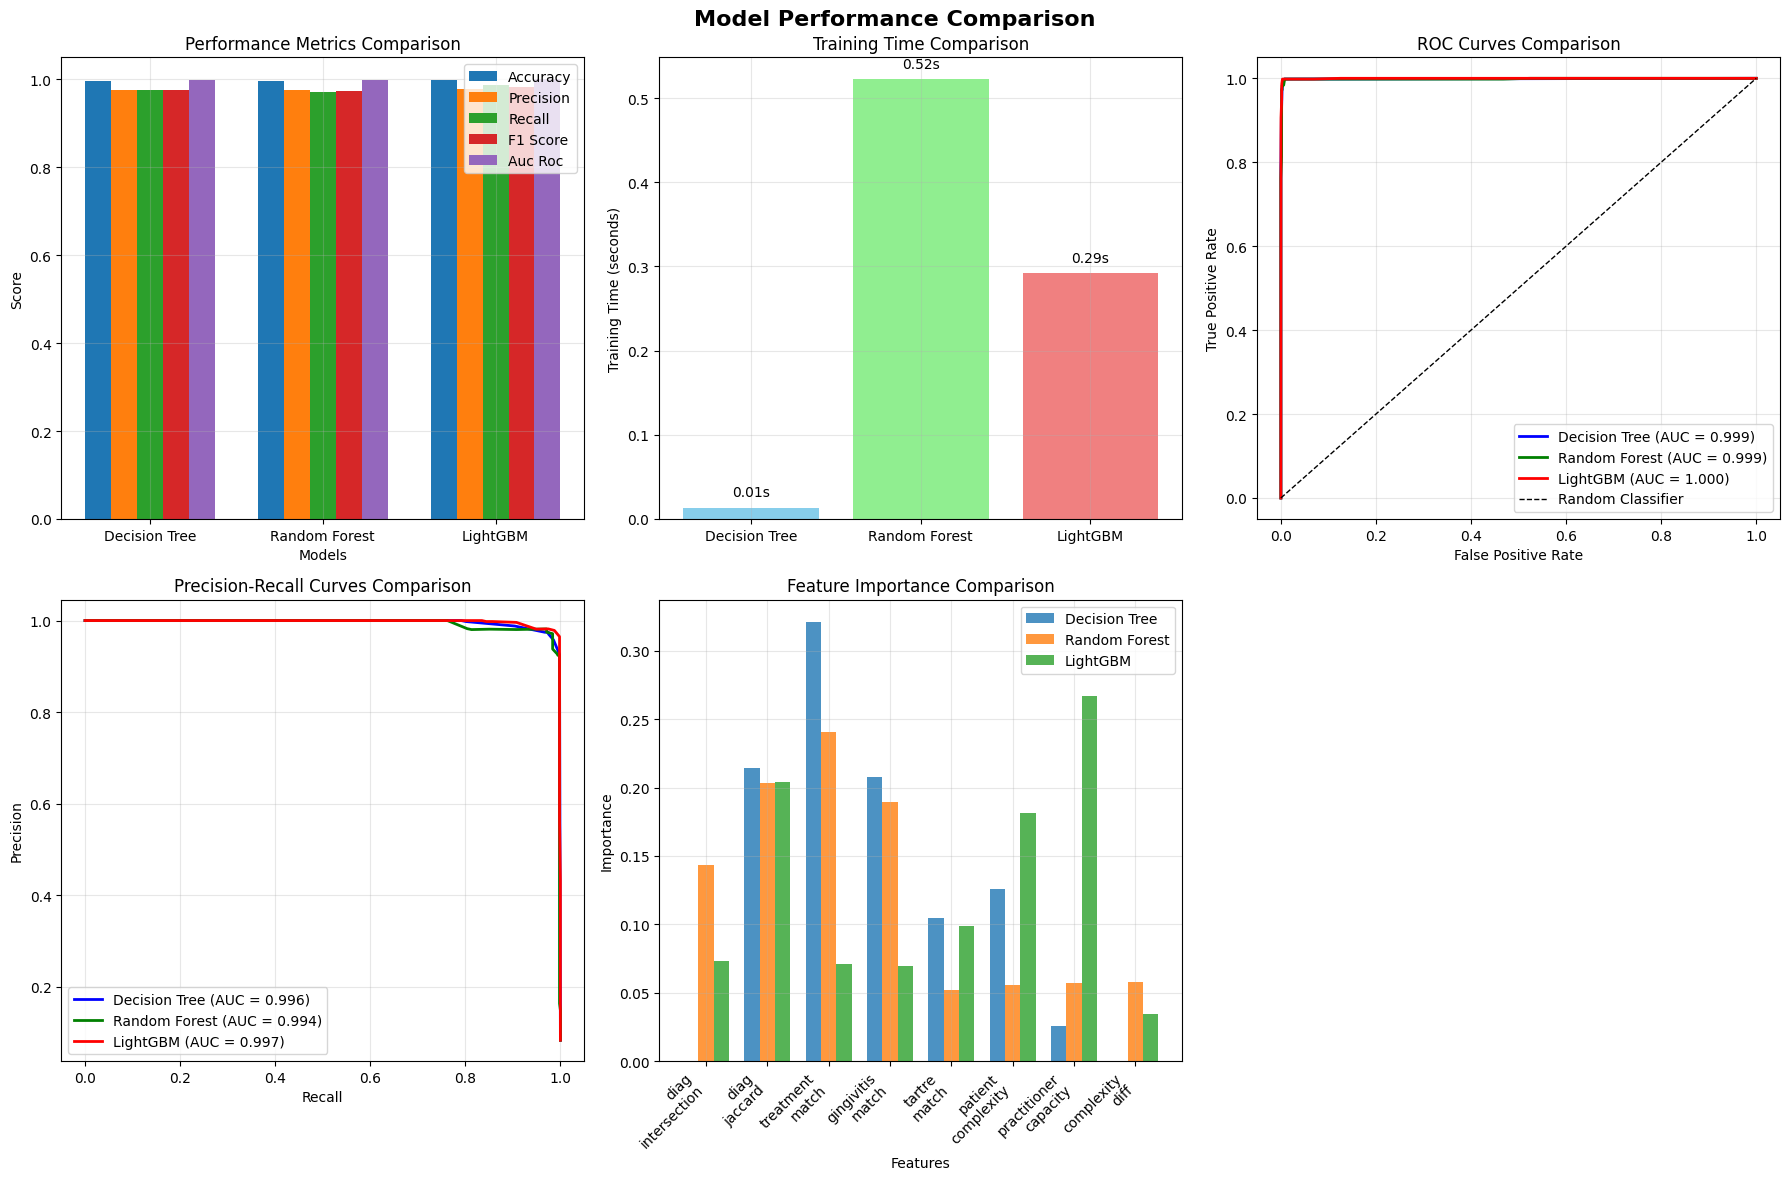

📊 Model comparison figure saved as './model_results/TrainingResults/model_comparison.png'


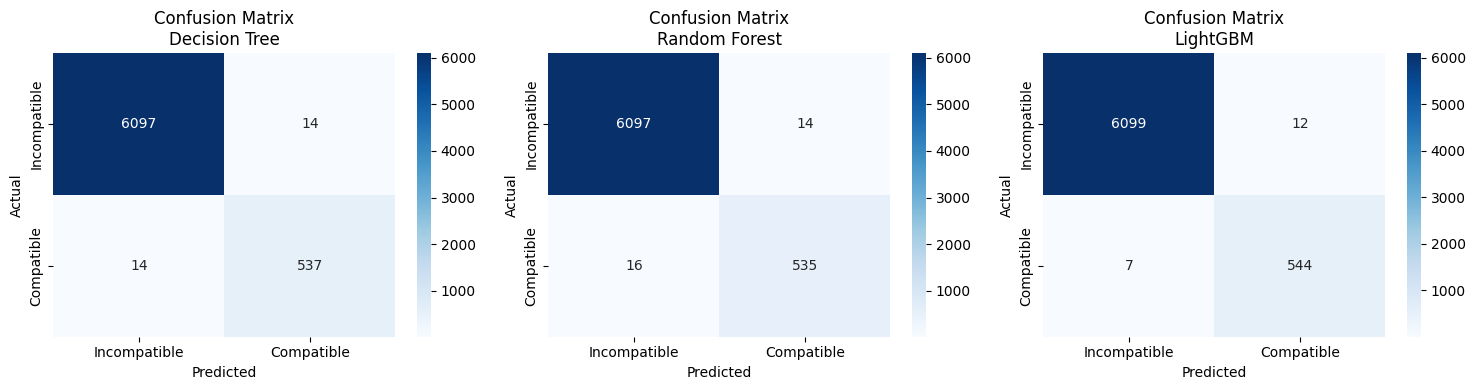

📊 Confusion matrices side-by-side saved at: './model_results/TrainingResults/confusion_matrices_side_by_side.png'
📊 Confusion matrix saved for Decision Tree at: ./model_results/TrainingResults/confusion_matrix_Decision_Tree.png
📊 Confusion matrix saved for Random Forest at: ./model_results/TrainingResults/confusion_matrix_Random_Forest.png
📊 Confusion matrix saved for LightGBM at: ./model_results/TrainingResults/confusion_matrix_LightGBM.png


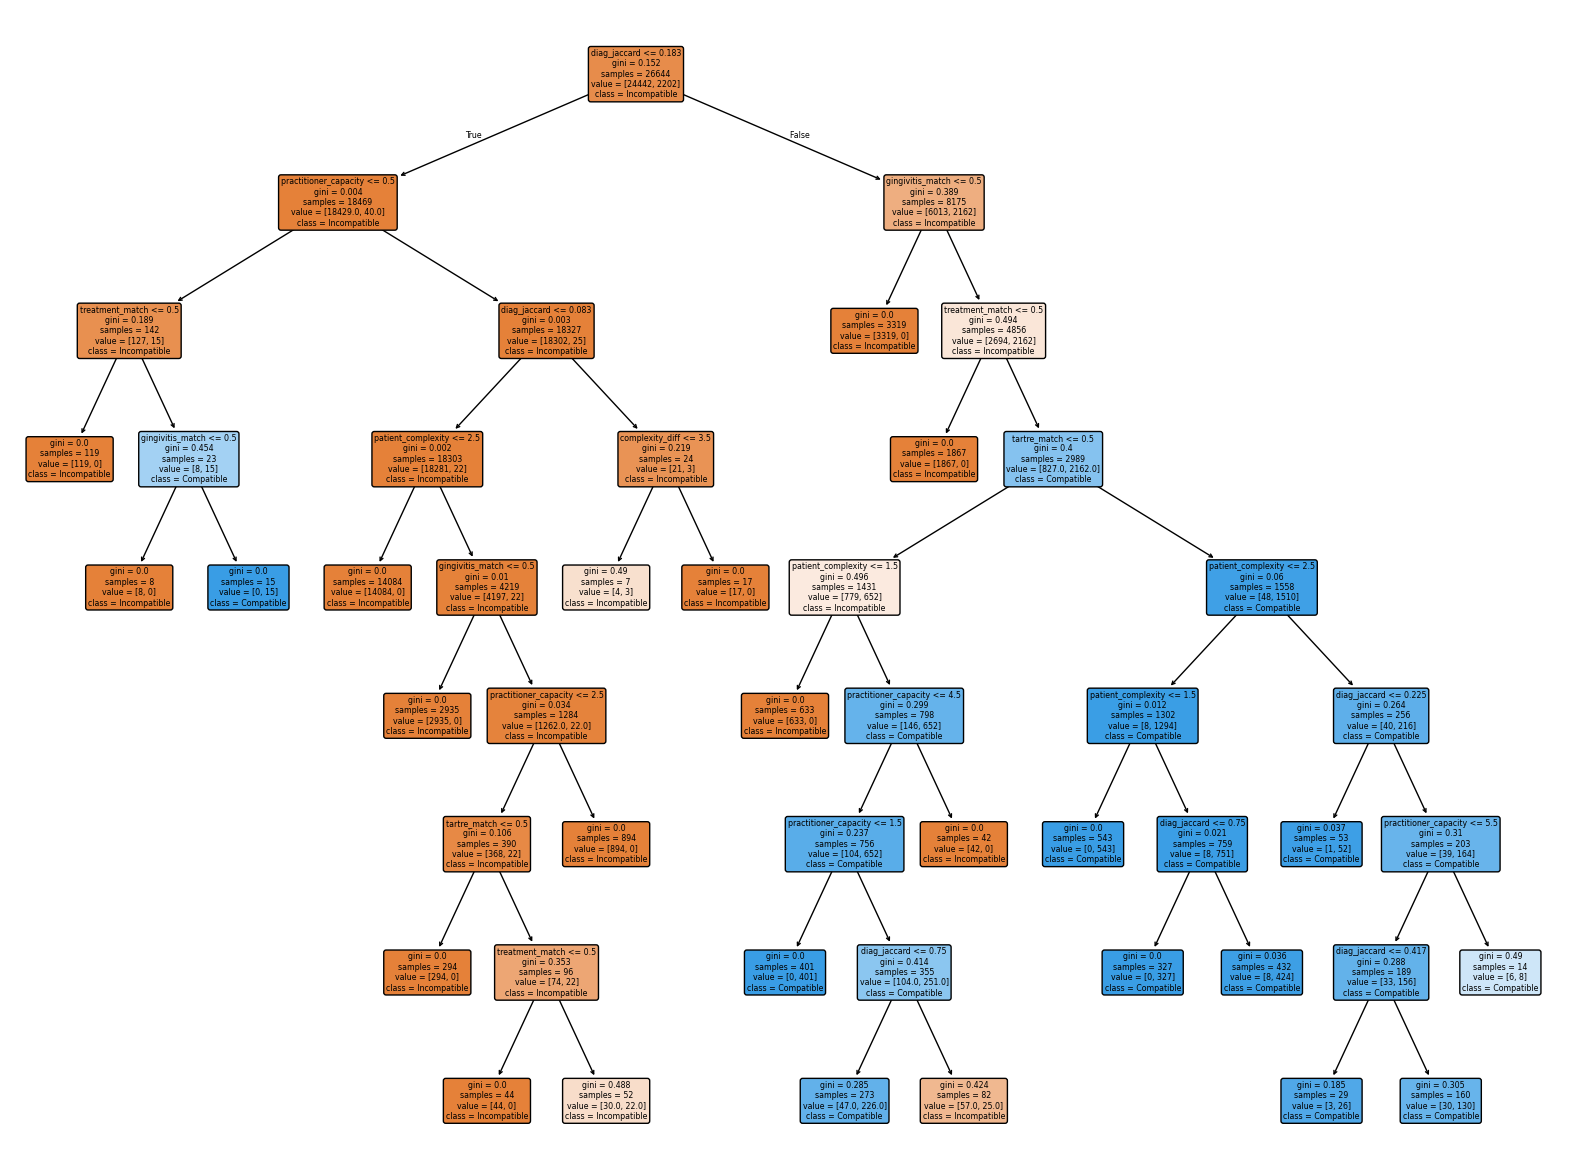

🌳 Decision Tree diagram saved at: ./model_results/TrainingResults/decision_tree.png


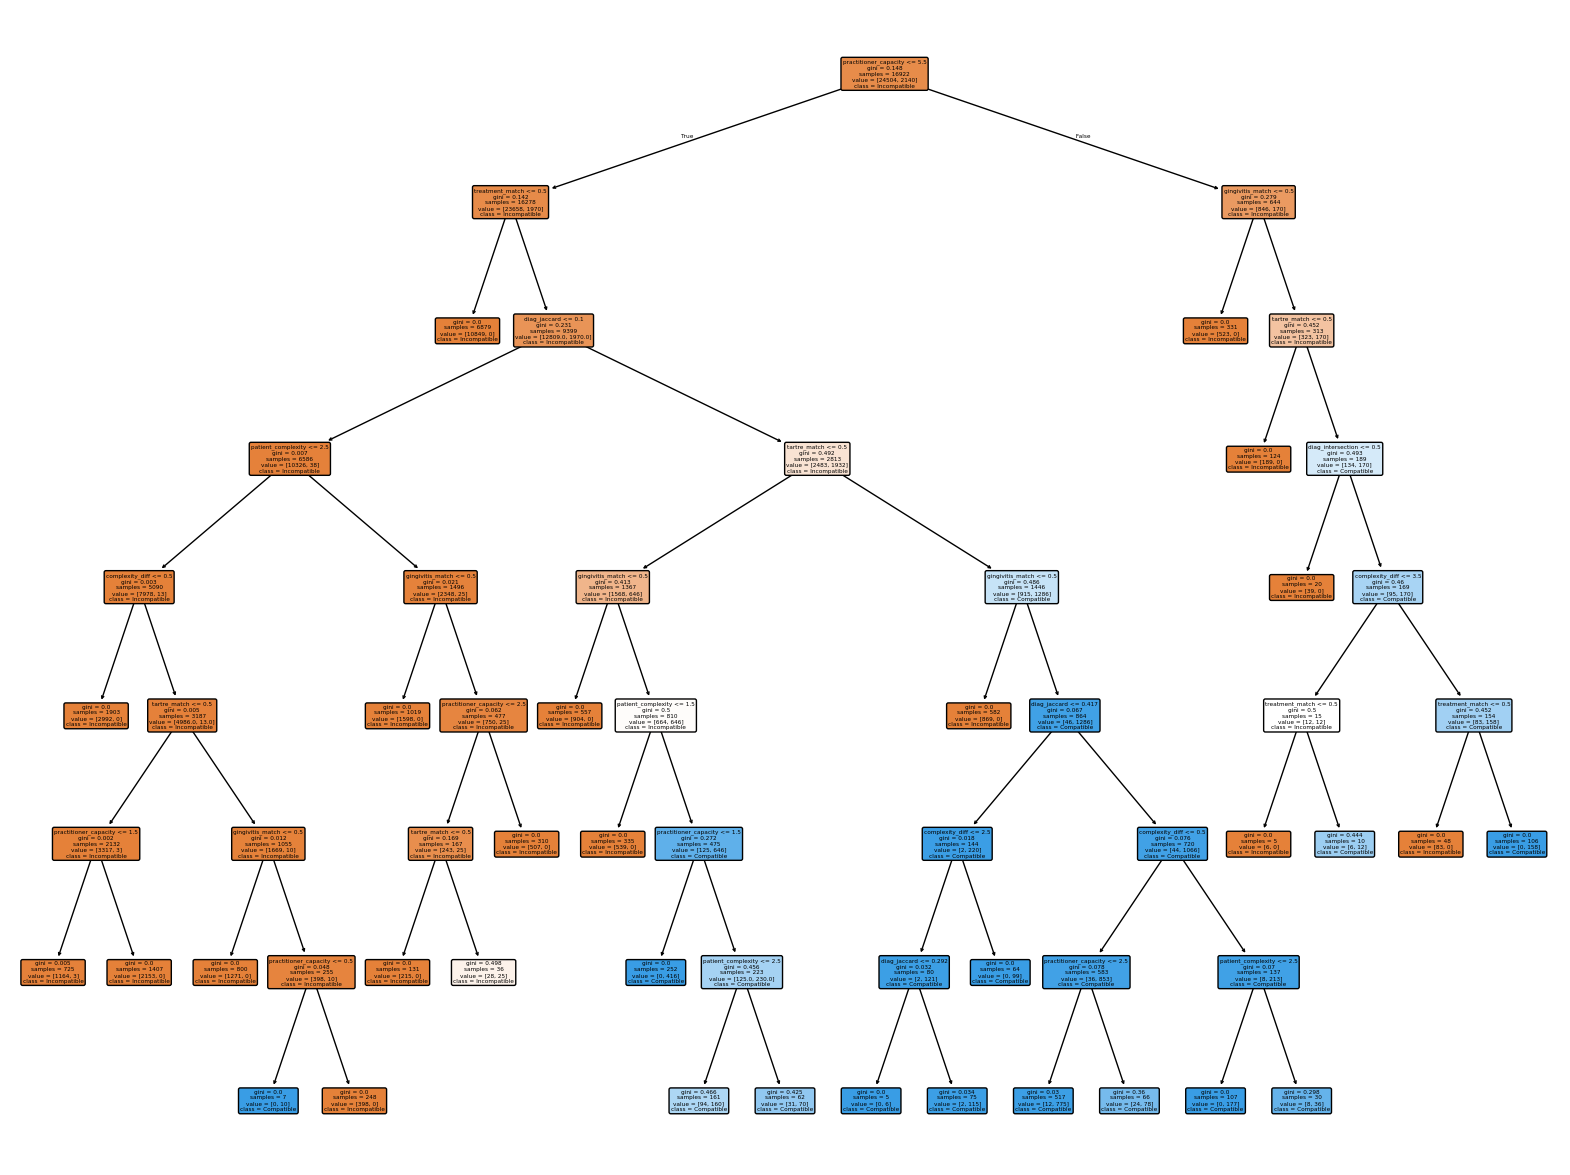

🌲 Random Forest tree #0 diagram saved at: ./model_results/TrainingResults/random_forest_tree_0.png


<Figure size 2000x1500 with 0 Axes>

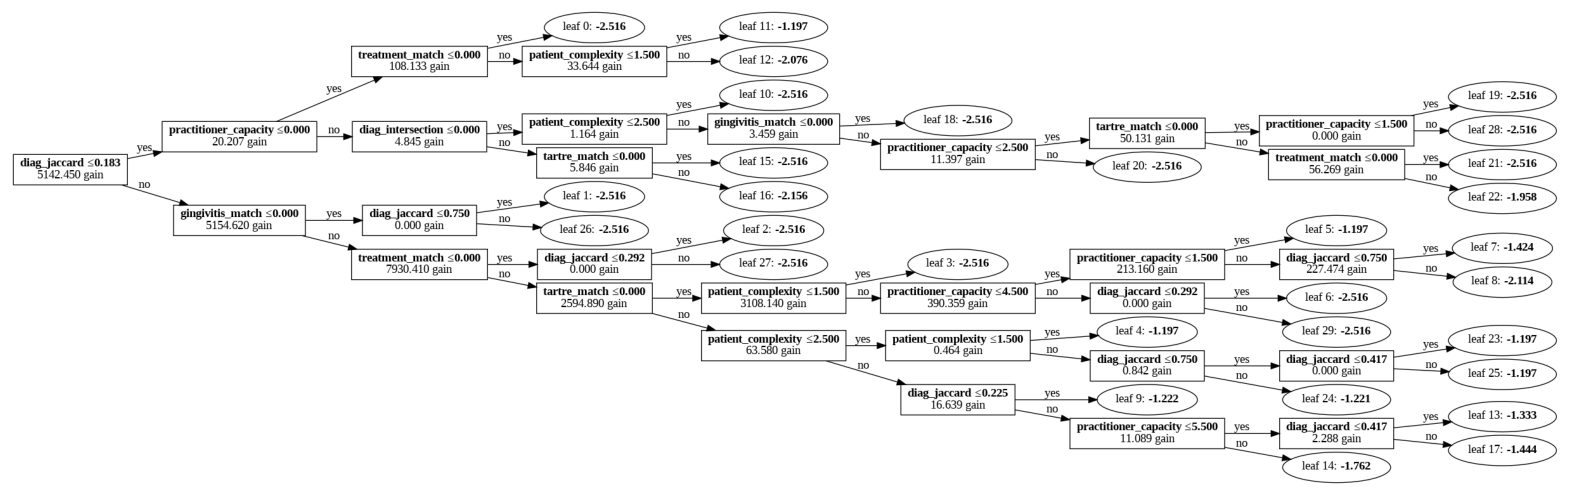

🌿 LightGBM best gain tree #0 diagram saved at: ./model_results/TrainingResults/lightgbm_best_gain_tree_0.png
Model metrics report PDF saved at: ./model_results/TrainingResults/model_metrics_report.pdf

📊 COMPREHENSIVE MODEL METRICS


,Model,Accuracy,Precision,Recall,F1 Score,Auc Roc,Matthews Corrcoef,Training Time
0,Decision Tree,0.9958,0.9746,0.9746,0.9746,0.9988,0.9723,0.01s
1,Random Forest,0.9955,0.9745,0.9710,0.9727,0.9987,0.9703,0.52s
2,LightGBM,0.9971,0.9784,0.9873,0.9828,0.9997,0.9813,0.29s



🏆 BEST PERFORMING MODELS:
   • Best Accuracy: LightGBM (0.9971)
   • Best F1 Score: LightGBM (0.9828)
   • Best Auc Roc: LightGBM (0.9997)
   • Best Matthews Corrcoef: LightGBM (0.9813)
   • Fastest Training: Decision Tree (0.01s)


In [ ]:
# 🔄 Prepare Training Dataset for Machine Learning
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, log_loss, balanced_accuracy_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from fpdf import FPDF
from sklearn.utils.multiclass import unique_labels
from sklearn.calibration import calibration_curve
from sklearn import metrics
import numpy as np

print(" Building compatibility dataset for model training...")

compatibility_records = []

# 🔁 Generate all possible patient-practitioner combinations
for patient_idx, patient in patients_df.iterrows():
    for practitioner_idx, practitioner in practitioners_df.iterrows():
        #  Calculate compatibility features for this pair
        features = engineer.calculate_compatibility_features(patient, practitioner)

        #  Determine ground truth compatibility (target variable)
        features['is_compatible'] = int(engineer.is_compatible(patient, practitioner))

        compatibility_records.append(features)

# 📊 Convert to DataFrame for analysis
compatibility_df = pd.DataFrame(compatibility_records)

print(f" Compatibility dataset created:")
print(f"   • Total combinations: {len(compatibility_df):,}")
print(f"   • Compatible pairs: {compatibility_df['is_compatible'].sum():,}")
print(f"   • Incompatible pairs: {(~compatibility_df['is_compatible'].astype(bool)).sum():,}")
print(f"   • Compatibility rate: {compatibility_df['is_compatible'].mean():.1%}")
print("\n🔍 Sample of the compatibility dataset (first 10 rows):")
display(compatibility_df.head(10).style.set_properties(**{'text-align': 'left'}))
# Initialize the enhanced predictor
multi_predictor = MultiModelPredictor()

# Train all models
multi_predictor.train_all_models(compatibility_df)



##**Justification du choix d’un arbre représentatif pour chaque modèle**

Pour visualiser la structure des modèles basés sur des arbres, il est essentiel de présenter un arbre clair et interprétable.

- **Decision Tree** : Le modèle étant constitué d’un seul arbre, sa visualisation est directe et reflète intégralement la logique de décision.  
- **Random Forest** : Composé d’une multitude d’arbres faibles construits sur des sous-échantillons aléatoires, il n’existe pas d’arbre « meilleur » isolé. Le premier arbre de la forêt est donc choisi par convention comme exemple représentatif, permettant d’illustrer la structure typique sans complexité supplémentaire.  
- **LightGBM** : Ce modèle de boosting séquentiel combine plusieurs arbres faibles où chaque arbre corrige les erreurs précédentes. Afin de sélectionner un arbre significatif, on choisit celui ayant le gain total maximal (c’est-à-dire contribuant le plus à la réduction de l’erreur), ce qui offre une meilleure interprétation de la logique du modèle.

Ce choix permet ainsi de fournir une visualisation pertinente, compréhensible et fidèle à la nature spécifique de chaque modèle, tout en facilitant l’analyse et l’interprétation .

## **Phase 6 : Algorithme Avancé de Matching avec Suivi de Progression**

### **Objectif**

Mettre en œuvre un algorithme intelligent d’appariement entre patients et praticiens qui prend en compte :  
- Les besoins non satisfaits des patients  
- Les exigences non remplies des praticiens  
- Les contraintes de capacité (nombre maximal d’assignations par patient et praticien)  
- Les prédictions des modèles de machine learning pour valider la compatibilité

### **Fonctionnement**

1. **Initialisation**  
   - On crée des structures de données pour suivre les besoins non satisfaits des patients et les exigences non remplies des praticiens.  
   - On initialise des compteurs pour limiter à 3 le nombre d’assignations par patient et par praticien.

2. **Itérations d’assignation**  
   - À chaque itération, l’algorithme parcourt toutes les paires patient-praticien possibles qui restent éligibles.  
   - Pour chaque paire :  
     - Vérification de la compatibilité de base via les règles métier.  
     - Validation via le modèle ML choisi (Decision Tree, Random Forest ou LightGBM).  
     - Calcul d’un score de correspondance basé sur :  
       - Le nombre de diagnostics satisfaits  
       - La correspondance sur gingivite et tartre  
       - La concordance des traitements  

   - Sélection de la paire avec le meilleur score pour réaliser l’affectation.

3. **Mise à jour dynamique**  
   - Après chaque assignation, mise à jour des besoins/exigences restants des deux parties.  
   - Mise à jour des compteurs d’assignations.

4. **Critères d’arrêt**  
   - L’algorithme s’arrête quand le nombre maximal d’itérations est atteint ou qu’aucune nouvelle assignation ne peut être faite (absence de progrès).

### **Suivi de progression**

- Utilisation de la barre de progression `tqdm` pour visualiser :  
  - Le nombre d’itérations réalisées  
  - Le nombre d’assignations effectuées  
  - Le nombre de paires compatibles vérifiées  
  - Le nombre de paires validées par le modèle ML  
  - Le score de correspondance en cours

### **Résultats produits**

- Liste finale des assignations patient-praticien  
- Statistiques sur le nombre total d’assignations, patients assignés, praticiens utilisés  
- États des besoins et exigences non satisfaits à la fin du processus

---

### **Importance de cette phase**

- Combine la puissance prédictive des modèles ML avec une optimisation itérative respectant les contraintes réelles.  
- Permet d’obtenir un appariement efficace, satisfaisant au mieux les besoins cliniques et les capacités des praticiens.  
- Offre une transparence grâce au suivi de la progression et à la mise à jour dynamique des besoins.  
- Gère les limites opérationnelles (nombre max d’assignations) pour une solution réaliste.

---

In [ ]:
# 🎯 UPDATED Phase 6: Multi-Model Advanced Matching Algorithm with Progress Tracking
from tqdm import tqdm
import time

print("\n🚀 Initializing multi-model matching system...")

def run_matching_with_model(model_name, model, patients_df, practitioners_df, engineer):
    """Run the matching algorithm with a specific model"""
    print(f"\n🔄 Running matching with {model_name}...")

    # Initialize tracking systems for this model
    patient_unfulfilled_needs = defaultdict(set)
    practitioner_unfulfilled_requirements = defaultdict(set)
    patient_assigned_to_count = defaultdict(int)
    practitioner_slots_filled = defaultdict(int)
    patient_fulfilled_specific_needs = defaultdict(set)
    practitioner_fulfilled_specific_requirements = defaultdict(set)
    existing_assignments = set()

    # Populate initial unfulfilled needs and requirements with progress bar
    print(f"   📋 Initializing patient needs...")
    for _, patient in tqdm(patients_df.iterrows(), total=len(patients_df), desc="Patient needs", leave=False):
        pid = patient['id']
        patient_unfulfilled_needs[pid].update(patient['diagnostics_clean'])
        if patient['has_gingivite'] != 'non':
            patient_unfulfilled_needs[pid].add('gingivite_patient')
        if patient['has_tartre'] == 'oui':
            patient_unfulfilled_needs[pid].add('tartre_patient')

    print(f"   📋 Initializing practitioner requirements...")
    for _, practitioner in tqdm(practitioners_df.iterrows(), total=len(practitioners_df), desc="Practitioner reqs", leave=False):
        prid = practitioner['id']
        practitioner_unfulfilled_requirements[prid].update(practitioner['required_diagnostics_clean'])
        if practitioner['needs_gingivite'] != 'non':
            practitioner_unfulfilled_requirements[prid].add('gingivite_prac')
        if practitioner['needs_tartre'] == 'oui':
            practitioner_unfulfilled_requirements[prid].add('tartre_prac')

    # Final assignment storage
    final_assignments = defaultdict(list)

    # Matching loop with progress tracking
    iteration = 0
    max_iterations = 500
    consecutive_no_progress = 0
    max_no_progress = 10

    print(f"   🔄 Starting matching iterations...")

    # Create progress bar for iterations
    with tqdm(total=max_iterations, desc=f"{model_name} matching",
              bar_format='{l_bar}{bar}| {n}/{total} [{elapsed}<{remaining}, {rate_fmt}] {postfix}') as pbar:

        while iteration < max_iterations and consecutive_no_progress < max_no_progress:
            iteration += 1
            best_match_score = -1
            best_patient_id = None
            best_practitioner_id = None

            # Track statistics for this iteration
            compatible_pairs_checked = 0
            ml_approved_pairs = 0

            # Patient-practitioner matching loop
            for patient_idx, patient in patients_df.iterrows():
                pid = patient['id']
                if not patient_unfulfilled_needs[pid] or patient_assigned_to_count[pid] >= 3:
                    continue

                for practitioner_idx, practitioner in practitioners_df.iterrows():
                    prid = practitioner['id']
                    if not practitioner_unfulfilled_requirements[prid] or practitioner_slots_filled[prid] >= 3:
                        continue
                    if (pid, prid) in existing_assignments:
                        continue

                    # Basic compatibility check
                    if not engineer.is_compatible(patient, practitioner):
                        continue

                    compatible_pairs_checked += 1

                    # ML model validation - UPDATED TO USE CURRENT MODEL
                    features_dict = engineer.calculate_compatibility_features(patient, practitioner)
                    X_predict = pd.DataFrame([features_dict], columns=multi_predictor.feature_columns)

                    if not model.predict(X_predict)[0]:
                        continue

                    ml_approved_pairs += 1

                    # Calculate match score
                    current_patient_needs = patient_unfulfilled_needs[pid]
                    current_practitioner_reqs = practitioner_unfulfilled_requirements[prid]
                    diag_overlap = current_patient_needs.intersection(current_practitioner_reqs)

                    gingivitis_match = ('gingivite_prac' in current_practitioner_reqs and
                                      'gingivite_patient' in current_patient_needs)
                    tartre_match = ('tartre_prac' in current_practitioner_reqs and
                                   'tartre_patient' in current_patient_needs)

                    current_match_score = (len(diag_overlap) +
                                         (1 if gingivitis_match else 0) +
                                         (1 if tartre_match else 0))

                    if patient['treatment'] == practitioner['required_treatment']:
                        current_match_score += 1

                    if current_match_score > best_match_score:
                        best_match_score = current_match_score
                        best_patient_id = pid
                        best_practitioner_id = prid
                    elif current_match_score == best_match_score and current_match_score > 0:
                        current_jaccard = features_dict['diag_jaccard']
                        best_features = engineer.calculate_compatibility_features(
                            patients_df[patients_df['id'] == best_patient_id].iloc[0],
                            practitioners_df[practitioners_df['id'] == best_practitioner_id].iloc[0]
                        )
                        if current_jaccard > best_features['diag_jaccard']:
                            best_patient_id = pid
                            best_practitioner_id = prid

            # Update progress bar with current stats
            total_assignments = sum(len(patients_list) for patients_list in final_assignments.values())
            assigned_patients = len(set(patient['id'] for patients_list in final_assignments.values()
                                      for patient in patients_list))

            pbar.set_postfix({
                'Assignments': total_assignments,
                'Patients': f"{assigned_patients}/{len(patients_df)}",
                'Score': f"{best_match_score:.1f}",
                'Checked': compatible_pairs_checked,
                'ML-OK': ml_approved_pairs,
                'No-Progress': consecutive_no_progress
            })

            if best_match_score <= 0 or best_patient_id is None:
                consecutive_no_progress += 1
                pbar.update(1)
                continue
            else:
                consecutive_no_progress = 0

            # Execute assignment
            patient = patients_df[patients_df['id'] == best_patient_id].iloc[0]
            practitioner = practitioners_df[practitioners_df['id'] == best_practitioner_id].iloc[0]

            existing_assignments.add((best_patient_id, best_practitioner_id))
            final_assignments[best_practitioner_id].append(patient)
            practitioner_slots_filled[best_practitioner_id] += 1
            patient_assigned_to_count[best_patient_id] += 1

            # Update tracking (same logic as original)
            fulfilled_diags = patient_unfulfilled_needs[best_patient_id].intersection(
                practitioner['required_diagnostics_clean']
            )
            for diag in fulfilled_diags:
                patient_unfulfilled_needs[best_patient_id].discard(diag)
                patient_fulfilled_specific_needs[best_patient_id].add(diag)

            if ('gingivite_patient' in patient_unfulfilled_needs[best_patient_id] and
                practitioner['needs_gingivite'] != 'non'):
                patient_unfulfilled_needs[best_patient_id].discard('gingivite_patient')
                patient_fulfilled_specific_needs[best_patient_id].add('gingivite_patient')

            if ('tartre_patient' in patient_unfulfilled_needs[best_patient_id] and
                practitioner['needs_tartre'] == 'oui'):
                patient_unfulfilled_needs[best_patient_id].discard('tartre_patient')
                patient_fulfilled_specific_needs[best_patient_id].add('tartre_patient')

            fulfilled_prac_diags = practitioner_unfulfilled_requirements[best_practitioner_id].intersection(
                patient['diagnostics_clean']
            )
            for diag in fulfilled_prac_diags:
                practitioner_unfulfilled_requirements[best_practitioner_id].discard(diag)
                practitioner_fulfilled_specific_requirements[best_practitioner_id].add(diag)

            if ('gingivite_prac' in practitioner_unfulfilled_requirements[best_practitioner_id] and
                patient['has_gingivite'] != 'non'):
                practitioner_unfulfilled_requirements[best_practitioner_id].discard('gingivite_prac')
                practitioner_fulfilled_specific_requirements[best_practitioner_id].add('gingivite_prac')

            if ('tartre_prac' in practitioner_unfulfilled_requirements[best_practitioner_id] and
                patient['has_tartre'] == 'oui'):
                practitioner_unfulfilled_requirements[best_practitioner_id].discard('tartre_prac')
                practitioner_fulfilled_specific_requirements[best_practitioner_id].add('tartre_prac')

            pbar.update(1)

            # Add small delay to make progress visible (remove in production)
            time.sleep(0.01)

    # Calculate results for this model
    assigned_patients = set()
    for patients_list in final_assignments.values():
        for patient in patients_list:
            assigned_patients.add(patient['id'])

    total_assignments = sum(len(patients_list) for patients_list in final_assignments.values())

    print(f"✅ {model_name} completed:")
    print(f"   📊 Total assignments: {total_assignments}")
    print(f"   👤 Patients assigned: {len(assigned_patients)}/{len(patients_df)} ({len(assigned_patients)/len(patients_df):.1%})")
    print(f"   👨‍⚕️ Practitioners with assignments: {len(final_assignments)}")
    print(f"   🔄 Iterations completed: {iteration}")

    return {
        'model_name': model_name,
        'final_assignments': final_assignments,
        'assigned_patients': assigned_patients,
        'total_assignments': total_assignments,
        'patient_unfulfilled_needs': patient_unfulfilled_needs,
        'practitioner_unfulfilled_requirements': practitioner_unfulfilled_requirements,
        'patient_fulfilled_specific_needs': patient_fulfilled_specific_needs,
        'practitioner_fulfilled_specific_requirements': practitioner_fulfilled_specific_requirements,
        'patient_assigned_to_count': patient_assigned_to_count,
        'practitioner_slots_filled': practitioner_slots_filled,
        'iterations': iteration
    }

# Run matching with all three models with overall progress tracking
all_model_results = {}

print(f"\n🎯 Running matching across {len(multi_predictor.trained_models)} models...")

# Overall progress bar for all models
with tqdm(total=len(multi_predictor.trained_models), desc="Overall progress",
          bar_format='{l_bar}{bar}| {n}/{total} models [{elapsed}<{remaining}]') as overall_pbar:

    for model_name, model in multi_predictor.trained_models.items():
        overall_pbar.set_description(f"Processing {model_name}")
        result = run_matching_with_model(model_name, model, patients_df, practitioners_df, engineer)
        all_model_results[model_name] = result
        overall_pbar.update(1)

# Compare results across models
print("\n" + "="*80)
print("📊 MULTI-MODEL COMPARISON RESULTS")
print("="*80)

comparison_df_data = []
print("📊 Calculating comparison metrics...")

for model_name, result in tqdm(all_model_results.items(), desc="Calculating metrics"):
    total_patients = len(patients_df)
    total_practitioners = len(practitioners_df)

    # Calculate satisfaction rates
    fully_satisfied_patients = sum(1 for pid in patients_df['id']
                                 if not result['patient_unfulfilled_needs'][pid])
    fully_satisfied_practitioners = sum(1 for prid in practitioners_df['id']
                                      if not result['practitioner_unfulfilled_requirements'][prid])

    comparison_df_data.append({
        'Model': model_name,
        'Total Assignments': result['total_assignments'],
        'Patients Assigned': f"{len(result['assigned_patients'])}/{total_patients}",
        'Assignment Rate': f"{len(result['assigned_patients'])/total_patients:.1%}",
        'Practitioners Used': f"{len(result['final_assignments'])}/{total_practitioners}",
        'Utilization Rate': f"{len(result['final_assignments'])/total_practitioners:.1%}",
        'Fully Satisfied Patients': f"{fully_satisfied_patients}/{total_patients}",
        'Patient Satisfaction': f"{fully_satisfied_patients/total_patients:.1%}",
        'Fully Satisfied Practitioners': f"{fully_satisfied_practitioners}/{total_practitioners}",
        'Practitioner Satisfaction': f"{fully_satisfied_practitioners/total_practitioners:.1%}",
        'Iterations': result['iterations']
    })

comparison_df = pd.DataFrame(comparison_df_data)
print(comparison_df.to_string(index=False))

# Identify best performing model for different metrics
print("\n🏆 BEST PERFORMING MODELS:")
best_assignment_rate = max(all_model_results.keys(),
                          key=lambda x: len(all_model_results[x]['assigned_patients'])/len(patients_df))
best_total_assignments = max(all_model_results.keys(),
                           key=lambda x: all_model_results[x]['total_assignments'])

print(f"   • Best Assignment Rate: {best_assignment_rate}")
print(f"   • Most Total Assignments: {best_total_assignments}")

# Store results for report generation
final_assignments = all_model_results  # This will be used in Phase 7

print("\n🎉 Multi-model matching completed successfully!")
print(f"📊 Processed {len(all_model_results)} models with full progress tracking")


🚀 Initializing multi-model matching system...

🎯 Running matching across 3 models...


Processing Decision Tree:   0%|          | 0/3 models [00:00<?]


🔄 Running matching with Decision Tree...
   📋 Initializing patient needs...



Patient needs:   0%|          | 0/182 [00:00<?, ?it/s]
                                                      

   📋 Initializing practitioner requirements...



Practitioner reqs:   0%|          | 0/183 [00:00<?, ?it/s]
                                                          

   🔄 Starting matching iterations...



Decision Tree matching:  20%|█▉        | 198/1000 [10:53<44:05,  3.30s/it] , Assignments=188, Patients=178/182, Score=-1.0, Checked=1, ML-OK=0, No-Progress=9
Processing Random Forest:  33%|███▎      | 1/3 models [10:53<21:46]

✅ Decision Tree completed:
   📊 Total assignments: 188
   👤 Patients assigned: 178/182 (97.8%)
   👨‍⚕️ Practitioners with assignments: 166
   🔄 Iterations completed: 198

🔄 Running matching with Random Forest...
   📋 Initializing patient needs...



Patient needs:   0%|          | 0/182 [00:00<?, ?it/s]
                                                      

   📋 Initializing practitioner requirements...



Practitioner reqs:   0%|          | 0/183 [00:00<?, ?it/s]
                                                          

   🔄 Starting matching iterations...



Random Forest matching:  20%|█▉        | 197/1000 [1:45:16<7:09:07, 32.06s/it] , Assignments=187, Patients=177/182, Score=-1.0, Checked=2, ML-OK=0, No-Progress=9
Processing LightGBM:  67%|██████▋   | 2/3 models [1:56:10<1:06:24]     

✅ Random Forest completed:
   📊 Total assignments: 187
   👤 Patients assigned: 177/182 (97.3%)
   👨‍⚕️ Practitioners with assignments: 166
   🔄 Iterations completed: 197

🔄 Running matching with LightGBM...
   📋 Initializing patient needs...



Patient needs:   0%|          | 0/182 [00:00<?, ?it/s]
                                                      

   📋 Initializing practitioner requirements...



Practitioner reqs:   0%|          | 0/183 [00:00<?, ?it/s]
                                                          

   🔄 Starting matching iterations...



LightGBM matching:  20%|█▉        | 199/1000 [10:34<42:35,  3.19s/it] , Assignments=189, Patients=178/182, Score=-1.0, Checked=1, ML-OK=0, No-Progress=9
Processing LightGBM: 100%|██████████| 3/3 models [2:06:45<00:00]


✅ LightGBM completed:
   📊 Total assignments: 189
   👤 Patients assigned: 178/182 (97.8%)
   👨‍⚕️ Practitioners with assignments: 166
   🔄 Iterations completed: 199

📊 MULTI-MODEL COMPARISON RESULTS
📊 Calculating comparison metrics...


Calculating metrics: 100%|██████████| 3/3 [00:00<00:00, 3573.68it/s]


        Model  Total Assignments Patients Assigned Assignment Rate Practitioners Used Utilization Rate Fully Satisfied Patients Patient Satisfaction Fully Satisfied Practitioners Practitioner Satisfaction  Iterations
Decision Tree                188           178/182           97.8%            166/183            90.7%                  172/182                94.5%                       140/183                     76.5%         198
Random Forest                187           177/182           97.3%            166/183            90.7%                  172/182                94.5%                       140/183                     76.5%         197
     LightGBM                189           178/182           97.8%            166/183            90.7%                  172/182                94.5%                       141/183                     77.0%         199

🏆 BEST PERFORMING MODELS:
   • Best Assignment Rate: Decision Tree
   • Most Total Assignments: LightGBM

🎉 Multi-model matching co

## **Phase 7 : Génération de Rapports & Visualisations**

### **Objectif**

Produire des rapports synthétiques et des visualisations claires permettant d’analyser et de communiquer les résultats des différents modèles de matching entre patients et praticiens.

### **Visualisations**

- **Graphiques comparatifs multi-modèles** :  
  - Taux d’assignation des patients par modèle  
  - Nombre total d’assignations effectuées  
  - Taux d’utilisation des praticiens  
  - Taux de satisfaction des patients et des praticiens (besoins/exigences satisfaits)  

### **Rapports PDF**

- Création automatique d’un rapport PDF structuré comprenant :  
  - Un résumé exécutif par modèle (statistiques clés, taux de succès)  
  - Détail des assignations par praticien, avec informations sur les patients affectés  
  - Analyse des praticiens et patients partiellement ou non assignés  
  - Indication des besoins ou exigences satisfaits et non satisfaits, avec mise en couleur (vert/rouge)  
  - Sections claires, polices adaptées, et pagination

### **Utilité**

- Facilite la lecture et la compréhension des résultats par les décideurs, médecins ou équipes projets.  
- Permet d’identifier rapidement les forces et faiblesses des modèles.  
- Support utile pour la présentation orale, la validation clinique et la documentation.



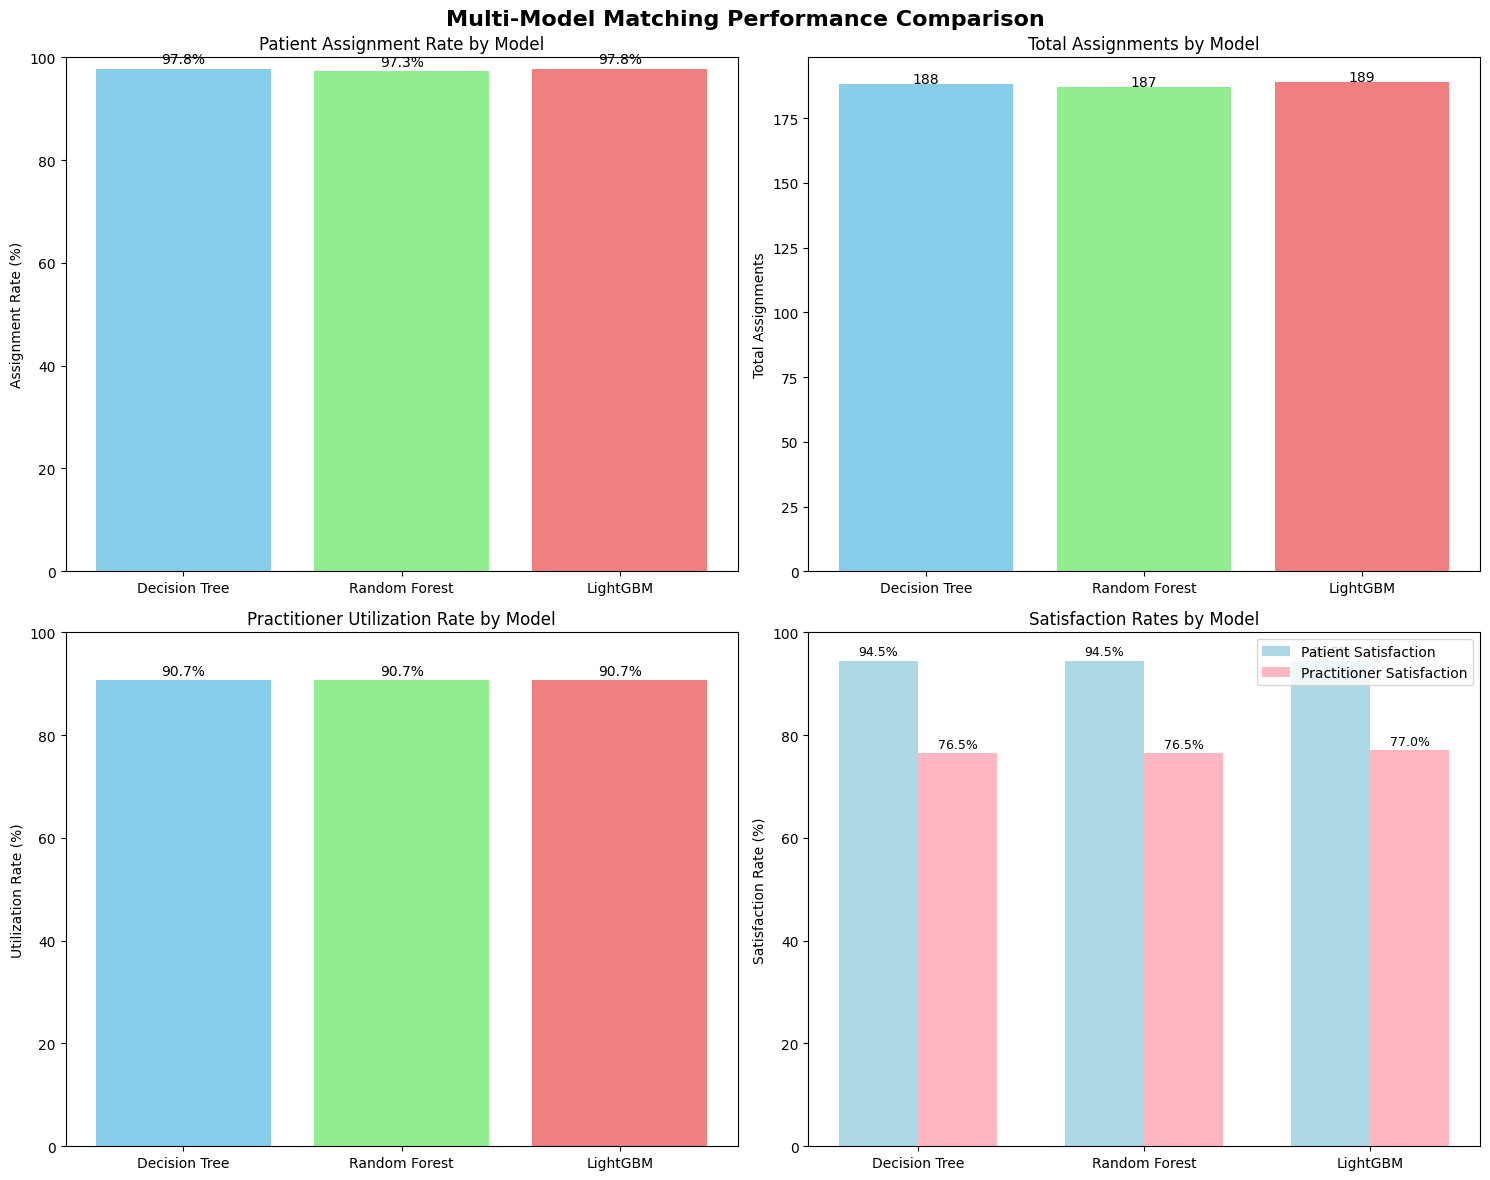

📊 Multi-model comparison chart saved as './model_results/MatchingReports/multi_model_comparison.png' and displayed.
📊 Multi-model comparison chart saved as 'multi_model_comparison.png' and displayed.
✅ Report for Decision Tree saved as './model_results/MatchingReports/decision_tree_matching_report.pdf'
✅ Report for Random Forest saved as './model_results/MatchingReports/random_forest_matching_report.pdf'
✅ Report for LightGBM saved as './model_results/MatchingReports/lightgbm_matching_report.pdf'


In [ ]:
from fpdf import FPDF
output_dir = "./model_results/MatchingReports"
os.makedirs(output_dir, exist_ok=True)
def create_model_comparison_chart():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Multi-Model Matching Performance Comparison', fontsize=16, fontweight='bold')
    model_names = list(all_model_results.keys())
    colors = ['skyblue', 'lightgreen', 'lightcoral']

    # 1) Taux d’assignation patients
    ax1 = axes[0, 0]
    assignment_rates = [len(all_model_results[m]['assigned_patients'])/len(patients_df)*100 for m in model_names]
    bars1 = ax1.bar(model_names, assignment_rates, color=colors)
    ax1.set_ylabel('Assignment Rate (%)')
    ax1.set_title('Patient Assignment Rate by Model')
    ax1.set_ylim(0, 100)
    for bar, rate in zip(bars1, assignment_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{rate:.1f}%', ha='center')

    # 2) Total Assignments
    ax2 = axes[0, 1]
    total_assignments = [all_model_results[m]['total_assignments'] for m in model_names]
    bars2 = ax2.bar(model_names, total_assignments, color=colors)
    ax2.set_ylabel('Total Assignments')
    ax2.set_title('Total Assignments by Model')
    for bar, val in zip(bars2, total_assignments):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val}', ha='center')

    # 3) Taux d’utilisation praticiens
    ax3 = axes[1, 0]
    utilization_rates = [len(all_model_results[m]['final_assignments'])/len(practitioners_df)*100 for m in model_names]
    bars3 = ax3.bar(model_names, utilization_rates, color=colors)
    ax3.set_ylabel('Utilization Rate (%)')
    ax3.set_title('Practitioner Utilization Rate by Model')
    ax3.set_ylim(0, 100)
    for bar, rate in zip(bars3, utilization_rates):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{rate:.1f}%', ha='center')

    # 4) Satisfaction patients & praticiens
    ax4 = axes[1, 1]
    patient_satisfaction = []
    practitioner_satisfaction = []
    for m in model_names:
        result = all_model_results[m]
        fully_satisfied_patients = sum(1 for pid in patients_df['id'] if not result['patient_unfulfilled_needs'][pid])
        fully_satisfied_practitioners = sum(1 for prid in practitioners_df['id'] if not result['practitioner_unfulfilled_requirements'][prid])
        patient_satisfaction.append(fully_satisfied_patients / len(patients_df) * 100)
        practitioner_satisfaction.append(fully_satisfied_practitioners / len(practitioners_df) * 100)
    x = np.arange(len(model_names))
    width = 0.35
    bars4a = ax4.bar(x - width/2, patient_satisfaction, width, label='Patient Satisfaction', color='lightblue')
    bars4b = ax4.bar(x + width/2, practitioner_satisfaction, width, label='Practitioner Satisfaction', color='lightpink')
    ax4.set_ylabel('Satisfaction Rate (%)')
    ax4.set_title('Satisfaction Rates by Model')
    ax4.set_xticks(x)
    ax4.set_xticklabels(model_names)
    ax4.legend()
    ax4.set_ylim(0, 100)
    for bars in [bars4a, bars4b]:
        for bar in bars:
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{bar.get_height():.1f}%', ha='center', fontsize=9)

    plt.tight_layout()

    png_path = os.path.join(output_dir, 'multi_model_comparison.png')
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Multi-model comparison chart saved as '{png_path}' and displayed.")

    # Affichage à la console (fenêtre graphique)
    plt.show()

    print("📊 Multi-model comparison chart saved as 'multi_model_comparison.png' and displayed.")

# Appeler la fonction
create_model_comparison_chart()
class MatchingReportPDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 16)
        self.cell(0, 10, 'Patient-Practitioner Matching Report', 0, 1, 'C')
        self.ln(5)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

def set_text_red_bold(pdf):
    pdf.set_text_color(220, 20, 20)
    pdf.set_font("Arial", "B")

def set_text_red_normal(pdf):
    pdf.set_text_color(220, 20, 20)
    pdf.set_font("Arial", "")

def set_text_green(pdf):
    pdf.set_text_color(0, 150, 0)
    pdf.set_font("Arial", "")

def set_text_normal(pdf):
    pdf.set_text_color(0, 0, 0)
    pdf.set_font("Arial", "")

for model_name, result in all_model_results.items():
    pdf = MatchingReportPDF()
    pdf.add_page()

    # Executive Summary
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 10, f"Executive Summary - {model_name}", ln=True)
    pdf.set_font("Arial", '', 11)
    pdf.ln(2)

    total_practitioners = len(practitioners_df)
    matched_practitioners = len(result['final_assignments'])
    total_patients = len(patients_df)
    assigned_patients_count = len(result['assigned_patients'])
    total_assignments = result['total_assignments']

    pdf.cell(0, 8, f"Total Practitioners: {total_practitioners}", ln=True)
    pdf.cell(0, 8, f"Practitioners with Assignments: {matched_practitioners} ({matched_practitioners/total_practitioners:.1%})", ln=True)
    pdf.cell(0, 8, f"Total Patients: {total_patients}", ln=True)
    pdf.cell(0, 8, f"Patients Assigned: {assigned_patients_count} ({assigned_patients_count/total_patients:.1%})", ln=True)
    pdf.cell(0, 8, f"Total Assignments Made: {total_assignments}", ln=True)
    pdf.ln(8)

    # Practitioner Assignments
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 10, "Practitioner Assignments", ln=True)
    pdf.ln(3)

    for prac_id, patients_list in result['final_assignments'].items():
        practitioner = practitioners_df[practitioners_df['id'] == prac_id].iloc[0]
        pdf.set_font("Arial", 'B', 12)
        pdf.set_text_color(10, 10, 130)
        pdf.cell(0, 8, f"Practitioner ID: {prac_id}", ln=True)
        pdf.set_font("Arial", '', 10)
        pdf.set_text_color(0, 0, 0)
        pdf.cell(0, 6, f"  Required Treatment: {practitioner['required_treatment']}", ln=True)

        req_diags = ', '.join(practitioner['required_diagnostics_clean']) if practitioner['required_diagnostics_clean'] else 'None'
        pdf.cell(0, 6, f"  Required Diagnostics: {req_diags}", ln=True)
        pdf.cell(0, 6, f"  Needs Gingivitis: {practitioner['needs_gingivite']}", ln=True)
        pdf.cell(0, 6, f"  Needs Tartre: {practitioner['needs_tartre']}", ln=True)

        pdf.set_font("Arial", 'B', 10)
        pdf.cell(0, 6, f"  Assigned Patients: {len(patients_list)}/3", ln=True)

        fulfilled_prac = result['practitioner_fulfilled_specific_requirements'][prac_id]
        unfulfilled_prac = result['practitioner_unfulfilled_requirements'][prac_id]

        if fulfilled_prac:
            set_text_green(pdf)
            pdf.cell(0, 6, f"  Fulfilled Requirements: {', '.join(fulfilled_prac)}", ln=True)
        if unfulfilled_prac:
            set_text_red_bold(pdf)
            pdf.cell(0, 6, f"  Unfulfilled Requirements: {', '.join(unfulfilled_prac)}", ln=True)
        set_text_normal(pdf)

        pdf.set_font("Arial", '', 9)
        for patient in patients_list:
            diag_str = ', '.join(patient['diagnostics_clean']) if patient['diagnostics_clean'] else 'None'
            pdf.cell(0, 5, f"    - Patient {patient['id']}: {patient['treatment']} | {diag_str} | Gingivitis: {patient['has_gingivite']} | Tartre: {patient['has_tartre']}", ln=True)
            remaining_needs = result['patient_unfulfilled_needs'][patient['id']]
            fulfilled_needs = result['patient_fulfilled_specific_needs'][patient['id']]

            if fulfilled_needs:
                set_text_green(pdf)
                pdf.cell(0, 5, f"      Fulfilled needs: {', '.join(fulfilled_needs)}", ln=True)
            if remaining_needs:
                set_text_red_bold(pdf)
                pdf.cell(0, 5, f"      Unfulfilled needs: {', '.join(remaining_needs)}", ln=True)
            set_text_normal(pdf)

            pdf.cell(0, 5, f"      (Assigned to {result['patient_assigned_to_count'][patient['id']]}/3 practitioners)", ln=True)

        pdf.ln(4)

    # --- Practitioners partiellement et non assignés
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 10, "Practitioners Partially Fulfilled or Not Assigned", ln=True)
    pdf.set_font("Arial", '', 10)
    pdf.ln(4)

    practitioners_not_assigned = [prid for prid in practitioners_df['id'] if prid not in result['final_assignments']]
    practitioners_partially_assigned = [prid for prid in result['final_assignments'] if result['practitioner_unfulfilled_requirements'][prid]]

    if practitioners_not_assigned:
        pdf.set_font("Arial", 'B', 12)
        pdf.cell(0, 8, "Practitioners Not Assigned:", ln=True)
        pdf.set_font("Arial", '', 10)
        for prid in practitioners_not_assigned:
            practitioner = practitioners_df[practitioners_df['id'] == prid].iloc[0]
            pdf.cell(0, 6, f" - Practitioner ID: {prid} | Treatment: {practitioner['required_treatment']}", ln=True)
            set_text_red_bold(pdf)
            pdf.cell(0, 6, f"   Unfulfilled Requirements: {', '.join(result['practitioner_unfulfilled_requirements'][prid])}", ln=True)
            set_text_normal(pdf)
        pdf.ln(5)
    else:
        pdf.cell(0, 6, "All practitioners have at least one assignment.", ln=True)
        pdf.ln(5)

    if practitioners_partially_assigned:
        pdf.set_font("Arial", 'B', 12)
        pdf.cell(0, 8, "Practitioners Partially Assigned (with unfulfilled requirements):", ln=True)
        pdf.set_font("Arial", '', 10)
        for prid in practitioners_partially_assigned:
            practitioner = practitioners_df[practitioners_df['id'] == prid].iloc[0]
            pdf.cell(0, 6, f" - Practitioner ID: {prid} | Treatment: {practitioner['required_treatment']} | Assigned Patients: {len(result['final_assignments'][prid])}", ln=True)
            fulfilled = result['practitioner_fulfilled_specific_requirements'][prid]
            unfulfilled = result['practitioner_unfulfilled_requirements'][prid]
            if fulfilled:
                set_text_green(pdf)
                pdf.cell(0, 6, f"   Fulfilled Requirements: {', '.join(fulfilled)}", ln=True)
            if unfulfilled:
                set_text_red_normal(pdf)
                pdf.cell(0, 6, f"   Unfulfilled Requirements: {', '.join(unfulfilled)}", ln=True)
            set_text_normal(pdf)
        pdf.ln(5)
    else:
        pdf.cell(0, 6, "No partially assigned practitioners with unfulfilled requirements.", ln=True)
        pdf.ln(5)

    # --- Patients partiellement ou non assignés
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 10, "Patients Not Assigned or Partially Assigned", ln=True)
    pdf.set_font("Arial", '', 10)
    pdf.ln(4)

    unassigned_patients = [pid for pid in patients_df['id'] if pid not in result['assigned_patients']]
    partially_assigned_patients = [pid for pid, count in result['patient_assigned_to_count'].items() if count > 0 and result['patient_unfulfilled_needs'][pid]]

    if unassigned_patients:
        pdf.set_font("Arial", 'B', 12)
        pdf.cell(0, 8, "Unassigned Patients:", ln=True)
        pdf.set_font("Arial", '', 10)
        for pid in unassigned_patients:
            patient = patients_df[patients_df['id'] == pid].iloc[0]
            diag_str = ', '.join(patient['diagnostics_clean']) if patient['diagnostics_clean'] else 'None'
            pdf.cell(0, 6, f" - Patient {pid}: {patient['treatment']} | {diag_str} | Gingivitis: {patient['has_gingivite']} | Tartre: {patient['has_tartre']}", ln=True)
            set_text_red_bold(pdf)
            pdf.cell(0, 6, f"   Unfulfilled Needs: {', '.join(result['patient_unfulfilled_needs'][pid])}", ln=True)
            set_text_normal(pdf)
        pdf.ln(5)
    else:
        pdf.cell(0, 6, "All patients have been assigned to at least one practitioner.", ln=True)
        pdf.ln(5)

    if partially_assigned_patients:
        pdf.set_font("Arial", 'B', 12)
        pdf.cell(0, 8, "Partially Assigned Patients (with remaining needs):", ln=True)
        pdf.set_font("Arial", '', 10)
        for pid in partially_assigned_patients:
            patient = patients_df[patients_df['id'] == pid].iloc[0]
            diag_str = ', '.join(patient['diagnostics_clean']) if patient['diagnostics_clean'] else 'None'
            pdf.cell(0, 6, f" - Patient {pid}: {patient['treatment']} | {diag_str} | Gingivitis: {patient['has_gingivite']} | Tartre: {patient['has_tartre']}", ln=True)

            fulfilled_needs = result['patient_fulfilled_specific_needs'][pid]
            unfulfilled_needs = result['patient_unfulfilled_needs'][pid]

            if fulfilled_needs:
                set_text_green(pdf)
                pdf.cell(0, 6, f"   Fulfilled Needs: {', '.join(fulfilled_needs)}", ln=True)
            if unfulfilled_needs:
                set_text_red_normal(pdf)
                pdf.cell(0, 6, f"   Unfulfilled Needs: {', '.join(unfulfilled_needs)}", ln=True)
            set_text_normal(pdf)

            pdf.cell(0, 6, f"   Assigned to {result['patient_assigned_to_count'][pid]}/3 practitioners", ln=True)
        pdf.ln(5)
    else:
        pdf.cell(0, 6, "No partially assigned patients with remaining needs.", ln=True)
        pdf.ln(5)

    # Enregistrement PDF
    pdf_filename = f"{model_name.lower().replace(' ', '_')}_matching_report.pdf"
    pdf_path = os.path.join(output_dir, pdf_filename)
    pdf.output(pdf_path)
    print(f"✅ Report for {model_name} saved as '{pdf_path}'")



## **Phase 8 : Synthèse du Modèle, Fonctionnement & Intérêt du Matching Intelligent**

### **Description du Modèle**

Le modèle repose sur un ensemble de classifieurs supervisés (arbre de décision, forêt aléatoire, LightGBM) qui apprennent à prédire la compatibilité entre un patient et un praticien à partir de caractéristiques cliniques et métier soigneusement extraites.

Chaque modèle est entraîné sur un vaste dataset combinant toutes les paires possibles patient-praticien, avec une cible binaire indiquant si la paire est compatible selon des règles métier validées.

### **Fonctionnement de l’Algorithme de Matching**

L’algorithme de matching itératif utilise la prédiction du modèle ML comme filtre : seules les paires validées par le modèle sont considérées pour l’assignation.

Il respecte des contraintes fortes de capacité (max 3 patients par praticien et max 3 praticiens par patient), pour simuler une réalité opérationnelle.

À chaque itération, il sélectionne la meilleure correspondance selon un score combinant :

- Le nombre de diagnostics communs satisfaits  
- La correspondance des pathologies spécifiques (gingivite, tartre)  
- La concordance des traitements  

Les besoins non satisfaits des patients et exigences non remplies des praticiens sont mis à jour dynamiquement après chaque affectation, pour orienter les futures assignations.

### **Intérêt & Apports du Matching Intelligent**

- **Optimisation des Ressources Médicales :**  
  Permet d’allouer efficacement les praticiens aux patients en tenant compte à la fois des compétences, des besoins cliniques et des contraintes de charge.

- **Qualité des Soins Améliorée :**  
  Favorise un appariement précis, ce qui augmente les chances de satisfaction des patients et la couverture des besoins des praticiens.

- **Gain de Temps & Automatisation :**  
  Remplace les appariements manuels fastidieux par une solution automatique, rapide et reproductible, avec possibilité de mise à jour dynamique.

- **Transparence & Traçabilité :**  
  Grâce aux rapports détaillés, le système permet d’analyser les décisions, les assignations et les lacunes, facilitant la prise de décision et le suivi.

- **Extensibilité :**  
  Le framework est adaptable à d’autres contextes cliniques, avec ajout possible de nouvelles caractéristiques ou contraintes.

### **Utilisation Pratique**

Dans un établissement de santé ou un réseau de praticiens, ce système peut être déployé pour :

- Gérer les listes d’attente et répartir les patients selon les compétences disponibles.  
- Adapter le planning des praticiens en fonction des besoins réels.  
- Identifier les sous-couvertures ou les besoins de formation/priorisation.

Pour les patients, cela garantit une meilleure prise en charge personnalisée et évite les erreurs ou pertes de temps liées à un appariement inadéquat.

---

### **🎯 Résumé Final**

Ce projet propose une approche intégrée mêlant data science, intelligence artificielle et optimisation combinatoire pour résoudre un problème réel de santé publique : comment associer au mieux patients et praticiens selon leurs besoins et compétences spécifiques.

La combinaison de modèles ML robustes et d’un algorithme de matching intelligent permet d’obtenir des résultats performants et exploitables, avec un potentiel important d’amélioration continue et d’adaptation aux évolutions du système de santé.
